# Binary

In [17]:
sys = 'dpdo280k'
pdb = "/data/gulab/yzdai/dyz_project1/data/dppc_dopc_280k/dppc_dopc_280k_0us.gro"
trj = "/data/gulab/yzdai/dyz_project1/data/dppc_dopc_280k/traj-dpdo280k-0-10us-pbc.xtc"
HMM_phase_fn = '/data/gulab/yzdai/data4/phase_identification/plot/input/HMM/dpdo280k/train5-dpdo280k-rawdata.xvg'
atom_phase_fn = '/data/gulab/yzdai/data4/phase_identification/phase_out/dpdo280k/9000-10000/dpdo280k-rawdata.xvg'

# sys = 'dpdo290k'
# pdb="/data/gulab/yzdai/dyz_project1/data/dppc_dopc_290k/dppc_dopc_290k_0us.gro"
# trj="/data/gulab/yzdai/dyz_project1/data/dppc_dopc_290k/traj-dpdo290k-0-10us-pbc.xtc"
# HMM_phase_fn = '/data/gulab/yzdai/data4/phase_identification/plot/input/HMM/dpdo290k/train0-dpdo290k-rawdata.xvg'
# atom_phase_fn = '/data/gulab/yzdai/data4/phase_identification/phase_out/dpdo290k/9000-10000/dpdo290k-rawdata.xvg'

b = 9995
e = 10000
interval = 5

10000
upper--------------------------------------------------
PBC_points:	530	points_with_PBC:	1682
                     V_AREAS NUM CORRECT
lip_area:	576
lower--------------------------------------------------
PBC_points:	502	points_with_PBC:	1654
                     V_AREAS NUM CORRECT
lip_area:	576
-------------------------------------------------------
n_count_up:	1152	n_count_low:	1152
points_all_up:	1682	points_all_low:	1654


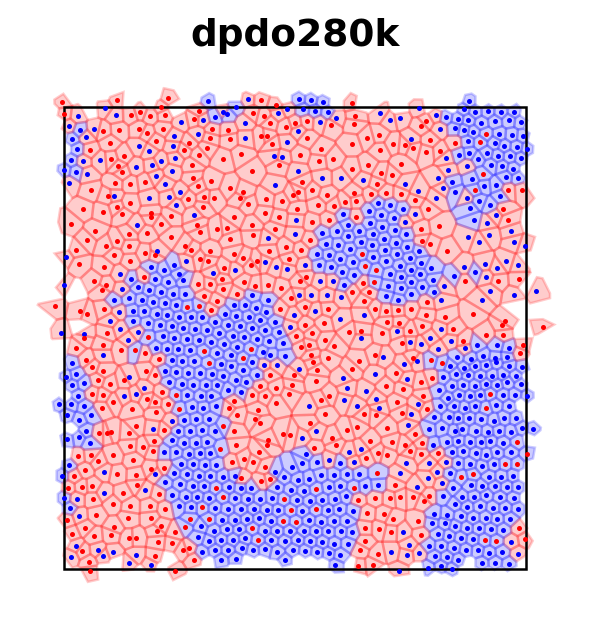

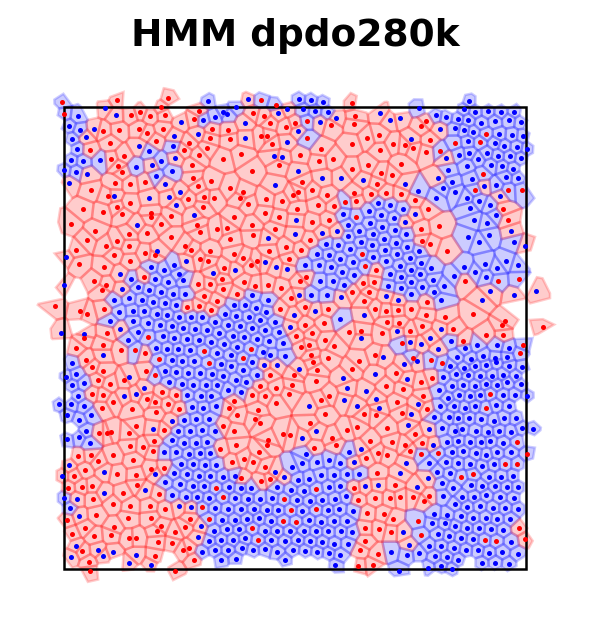

In [18]:
#考虑周期性边界条件的Voronoi tessellation
import MDAnalysis
from scipy.spatial import Voronoi
import numpy as np
import argparse
import math
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, ConvexHull
from collections import Counter

# 一些函数###########################################################################################################################
# 函数get_atom分别获得磷脂的两条疏水链的原子
def get_sn(sel_lip, sel_lip_type):
	sel_atom =[]
	for i in range(len(sel_lip)):
		if(sel_lip_type[i] == 'DPPC'):
			tmp_sn1 = sel_lip[i] + ' and (name C32 H2X H2Y C33 H3X H3Y C34 H4X H4Y C35 H5X H5Y C36 H6X H6Y C37 H7X H7Y\
									  C38 H8X H8Y C39 H9X H9Y C310 H10X H10Y C311 H11X H11Y C312 H12X H12Y C313 H13X H13Y\
									  C314 H14X H14Y C315 H15X H15Y C316 H16X H16Y H16Z)'
			tmp_sn2 = sel_lip[i] + ' and (name C22 H2R H2S C23 H3R H3S C24 H4R H4S C25 H5R H5S C26 H6R H6S C27 H7R H7S\
									  C28 H8R H8S C29 H9R H9S C210 H10R H10S C211 H11R H11S C212 H12R H12S C213 H13R H13S\
									  C214 H14R H14S C215 H15R H15S C216 H16R H16S H16T)'
		elif(sel_lip_type[i] == 'DOPC'):
			tmp_sn1 = sel_lip[i] + ' and (name C32 H2X H2Y C33 H3X H3Y C34 H4X H4Y C35 H5X H5Y C36 H6X H6Y C37 H7X H7Y\
									  C38 H8X H8Y C39 H9X C310 H10X C311 H11X H11Y C312 H12X H12Y C313 H13X H13Y\
									  C314 H14X H14Y C315 H15X H15Y C316 H16X H16Y C317 H17X H17Y C318 H18X H18Y H18Z)'
			tmp_sn2 = sel_lip[i] + ' and (name C22 H2R H2S C23 H3R H3S C24 H4R H4S C25 H5R H5S C26 H6R H6S C27 H7R H7S\
									  C28 H8R H8S C29 H9R C210 H10R C211 H11R H11S C212 H12R H12S C213 H13R H13S\
									  C214 H14R H14S C215 H15R H15S C216 H16R H16S C217 H17R H17S C218 H18R H18S H18T)' 
		elif(sel_lip_type[i] == 'POPC'):
			tmp_sn1 = sel_lip[i] + ' and (name C32 H2X H2Y C33 H3X H3Y C34 H4X H4Y C35 H5X H5Y C36 H6X H6Y C37 H7X H7Y\
									  C38 H8X H8Y C39 H9X H9Y C310 H10X H10Y C311 H11X H11Y C312 H12X H12Y C313 H13X H13Y\
									  C314 H14X H14Y C315 H15X H15Y C316 H16X H16Y H16Z)'
			tmp_sn2 = sel_lip[i] + ' and (name C22 H2R H2S C23 H3R H3S C24 H4R H4S C25 H5R H5S C26 H6R H6S C27 H7R H7S\
									  C28 H8R H8S C29 H91 C210 H101 C211 H11R H11S C212 H12R H12S C213 H13R H13S\
									  C214 H14R H14S C215 H15R H15S C216 H16R H16S C217 H17R H17S C218 H18R H18S H18T)'
		elif(sel_lip_type[i] == 'PSM'):
			tmp_sn1 = sel_lip[i] + ' and (name C2F H2F C3F H3F C4F H4F C5F H5F C6F H6F C7F H7F \
									  C8F H8F C9F H9F C10F H10F C11F H11F C12F H12F C13F H13F \
									  C14F H14F C15F H15F C16F H16F C2F H2G C3F H3G C4F H4G C5F H5G C6F H6G C7F H7G \
									   C8F H8G C9F H9G C10F H10G C11F H11G C12F H12G C13F H13G \
									   C14F H14G C15F H15G C16F H16G H16H)'
			tmp_sn2 = sel_lip[i] + ' and (name C6S H6S C7S H7S C8S H8S C9S H9S C10S H10S C11S H11S C12S H12S C13S H13S \
									  C14S H14S C15S H15S C16S H16S C17S H17S C18S H18S C6S H6T C7S H7T C8S H8T C9S H9T C10S H10T C11S H11T C12S H12T C13S H13T \
									  C14S H14T C15S H15T C16S H16T C17S H17T C18S H18T H18U)'
		sel_atom.append(tmp_sn1)
		sel_atom.append(tmp_sn2)
	return sel_atom
def getPolygonArea(points):

	sizep = len(points)
	if sizep<3:
		return 0.0

	area = points[-1][0] * points[0][1] - points[0][0] * points[-1][1]
	for i in range(1, sizep):
		v = i - 1
		area += (points[v][0] * points[i][1])
		area -= (points[i][0] * points[v][1])

	return abs(0.5 * area)
def calculate_lipid_Voronoi_area(points):
	# 计算 Voronoi 分割
	vor = Voronoi(points)
	#按照 points 的顺序对 vor.regions 进行排序
	sorted_regions = [vor.regions[vor.point_region[i]] for i in range(len(points))]
	# 计算每个 Voronoi 区域的面积
	areas = []
	boundary_points = []
	for region in sorted_regions:
		if -1 in region or len(region) == 0:
			# 跳过无效的区域
			areas.append(0)
			boundary_points.append(list(points[i]))
			continue
		# 获取区域的顶点坐标
		vertices = vor.vertices[region]
		# 计算区域的凸包
		area=getPolygonArea(vertices)
		# print('area',area)
		areas.append(area)
	# 检查
	if (len(areas) == len(points)):
		print('                     V_AREAS NUM CORRECT')
	else:
		print('!                    V_AREAS NUM ERROR')

	return areas, vor, sorted_regions, boundary_points
def plot_Voronoi(vor, sorted_regions, points, n_count, box, phase, title_str): #n_count = lip_num*2 + chol_num in one leaflet
	fig, ax = plt.subplots(figsize=(4, 4), dpi=180)
	# 多边形的画图部分
	for i in range(len(sorted_regions)):
		region = sorted_regions[i]
		if -1 in region or len(region) == 0:
			# 跳过无效的区域
			continue
		# 获取区域的顶点坐标
		vertices = vor.vertices[region]
		if(i < len(phase)):
			if(phase[i] == 1):
				ax.fill(*zip(*vertices), alpha=0.2, color='blue')
			elif(phase[i] == 0):
				ax.fill(*zip(*vertices), alpha=0.2, color='red')
		else:
			ax.fill(*zip(*vertices), alpha=0.0, color='white')        #PBC 多边形 

		# if(i<202*2):
		# # if(i<202*2 and i%2==0):
		#     ax.fill(*zip(*vertices), alpha=0.2, color='blue')          #DPPC 多边形
		# elif(i<404*2):
		# # elif(i<404*2 and i%2==0):
		#     #2个多边形融合
		#     ax.fill(*zip(*vertices), alpha=0.2, color='red')           #DOPC 多边形
		# elif(i<n_count):
		#     ax.fill(*zip(*vertices), alpha=0.2, color='orange')        #CHOL 多边形 
		# else:
		#     ax.fill(*zip(*vertices), alpha=0.1, color='grey')        #PBC 多边形 
			# break

	# 点的画图部分
	ax.plot(points[:692, 0], points[:692, 1], 'b.', markersize='2')               # DPPC 2疏水链脂心
	ax.plot(points[692:1152, 0], points[692:1152, 1], 'r.', markersize='2')     # DOPC 2疏水链脂心
	ax.plot(points[n_count:, 0], points[n_count:, 1], '.', color='white', markersize='2', alpha=0)            # PBC fake points
	# box画图部分                                        
	# 创建一个正方形的顶点坐标
	square = plt.Rectangle((0, 0), box[0], box[1], fill=False)
	# 将正方形添加到坐标轴上
	ax.add_patch(square)
	# 隐藏原始的坐标轴
	ax.axis('off')
	# 标记刻度和数字（仅显示左下两边的刻度和数字）
	# for i in range(20, 161, 40):
	#     # 左侧刻度及数字
	#     plt.plot([0, 2], [i, i], color='black', )  # 刻度线
	#     plt.text(-3, i, str(i), ha='right', va='center')  # 数字标签
	#     # 下方刻度及数字
	#     plt.plot([i, i], [0, 2], color='black')  # 刻度线
	#     plt.text(i, -3, str(i), ha='center', va='top')  # 数字标签
	# ax.axis('off')
	
	x_min = 0-0.1*box[0]
	x_max = 1.1*box[0]
	y_min = 0-0.1*box[1]
	y_max = 1.1*box[1]
	plt.xlim(x_min, x_max)
	plt.ylim(y_min, y_max)
	plt.title(title_str, fontsize= 15, fontweight='bold')
	plt.gca().set_aspect('equal')
	plt.savefig(
	'/data/gulab/yzdai/data4/phase_identification/plot/output/voronoi/'+title_str+'.png',        # 文件名
	dpi=350,             # 分辨率
	format='png',        # 文件格式
	bbox_inches='tight', # 自动调整边界框
	pad_inches=0.0,      # 边界填充
	# facecolor='white',   # 背景颜色
	# edgecolor='black',   # 边缘颜色
	transparent=True,   # 是否透明背景
	# metadata={'Author': 'Your Name'}  # 元数据
	)     
def simulate_PBC(points_leaflet, box):  # 改成 points leaflet判断并移动
	PBC_points = []
	x_min = 0-0.1*box[0]
	x_max = 1.1*box[0]
	y_min = 0-0.1*box[1]
	y_max = 1.1*box[1]
	for i in range(len(points_leaflet)):
		# 左移 
		if(points_leaflet[i, 0] > box[0]*0.9):
			x = points_leaflet[i, 0] - box[0]
			y = points_leaflet[i, 1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])
		# 右移 
		if(points_leaflet[i, 0] < box[0]*0.1):
			x = points_leaflet[i, 0] + box[0]
			y = points_leaflet[i, 1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])
		# 上移 
		if(points_leaflet[i, 1] < box[1]*0.1):
			x = points_leaflet[i, 0]
			y = points_leaflet[i, 1] + box[1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])            
		# 下移 
		if(points_leaflet[i, 1] > box[1]*0.9):
			x = points_leaflet[i, 0]
			y = points_leaflet[i, 1] - box[1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])            
		# 左上移  
		if(points_leaflet[i, 0] > box[0]*0.9 and points_leaflet[i, 1] < box[1]*0.1):
			x = points_leaflet[i, 0] - box[0]
			y = points_leaflet[i, 1] + box[1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])            
		# 左下移
		if(points_leaflet[i, 0] > box[0]*0.9 and points_leaflet[i, 1] > box[1]*0.9):
			x = points_leaflet[i, 0] - box[0]
			y = points_leaflet[i, 1] - box[1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])            
		# 右上移
		if(points_leaflet[i, 0] < box[0]*0.1 and points_leaflet[i, 1] < box[1]*0.1):
			x = points_leaflet[i, 0] + box[0]
			y = points_leaflet[i, 1] + box[1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])           
		# 右下移
		if(points_leaflet[i, 0] < box[0]*0.1 and points_leaflet[i, 1] > box[1]*0.9):
			x = points_leaflet[i, 0] + box[0]
			y = points_leaflet[i, 1] - box[1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])           
	PBC_points = np.array(PBC_points)
	return PBC_points
# 这里开始定义一个大函数，输入是每个片层选择的所有原子 包括chol
def leaflet_Vor(sel_atom_leaflet, count_leaflet_lip, box):
	# 获得所有Voronoi点的坐标
	points_leaflet = []
	for i in range(0, len(sel_atom_leaflet)):
		point = u.select_atoms(sel_atom_leaflet[i]).center_of_mass()
		points_leaflet.append(list(point[0:2]))
	points_leaflet = np.array(points_leaflet)
	# 记有效点数为 n_count == lip_num*2 + chol_num
	n_count = len(points_leaflet)

	# 对边界点进行8次处理
	PBC_points = simulate_PBC(points_leaflet, box)
	# 获得 points_with_PBC
	points_with_PBC = np.array(list(points_leaflet) + list(PBC_points))  # 直接在这里调函数simulate pbc

	print('PBC_points:\t' + str(len(PBC_points)) + '\tpoints_with_PBC:\t' + str(len(points_with_PBC)))
	# 对points_with_PBC进行Voronio tessellation 
	areas, vor, sorted_regions, _boundary_points = calculate_lipid_Voronoi_area(points_with_PBC)
	areas = areas[:n_count] #这里是每个非PBC点的面积，接下来我们要获得每个脂质的面积
	lip_area = []
	for i in range(0,count_leaflet_lip*2,2):
		if(areas[i]==0 or areas[i+1]==0):
			print('!                    FINAL AREAS ZERO ERROR')
			break
		else:
			tmp = areas[i] + areas[i+1]
			lip_area.append(tmp)
	print('lip_area:\t' + str(len(lip_area)))
	return lip_area, vor, sorted_regions, points_with_PBC
#识别共享边，确定相边界顶点，相边界索引
def share_boundary(vor,sorted_regions,tail_phase):
	i=0
	boundary_index=[]
	#选定一个区域作为中心区域
	m=0 
	# boundary_vertices=np.zeros((1,2))
	for i in range ( len(sorted_regions)):
		region=sorted_regions[i]   
		region_adjacent=[]
		region_adjacent_index=[]
		j=0
		#确定中心区域旁的相邻区域
		for tmp in sorted_regions:
			if len( list(set(region) & set(tmp)))>=2 and len( list(set(region) & set(tmp)))<len(region): #确定相邻区域，不包含中心区域
				share_vertices =  list(set(region) & set(tmp))
				region_adjacent.append(tmp)       
				region_adjacent_index.append(j)   #确定相邻区域的索引，不包含中心区域 
			j+=1
		#确定边界相区域1
		# share_vertices_num=0
		# for l in range(len(region_adjacent_index)):
		#     if len( list(set(region_adjacent[l]) & set(sorted_regions[i])))>0:
		#         # print( list(set(region_adjacent[l]) & set(sorted_regions[i])))
		#         share_vertices_num+=1
		#     if tail_phase[region_adjacent_index[l]]!=tail_phase[i] and share_vertices_num<3: #确定相邻区域与中心区域相态是否相同，若不同则中心区域为边界相区域
		#                                     #由于遍历所有区域，因此只需要判断中心区域是否为边界相区域，从而可得所有边界相区域
		#         boundary_index.append(i) 
		#         break
		#确定边界相区域2
		phase0_num=0
		phase1_num=0
		b_mol_if='no'
		for l in range(len(region_adjacent_index)):
			if tail_phase[region_adjacent_index[l]]==0 :
				phase0_num+=1
			else:
				# print( list(set(region_adjacent[l]) & set(sorted_regions[i])))
				phase1_num+=1
		for l in range(len(region_adjacent_index)):
			if tail_phase[region_adjacent_index[l]]!=tail_phase[i]:
				b_mol_if='yes'
				break
		if b_mol_if=='yes' and not \
		(phase0_num>len(region_adjacent_index)-2 or  phase1_num>len(region_adjacent_index)-2): #确定相邻区域与中心区域相态是否相同，若不同则中心区域为边界相区域
											#由于遍历所有区域，因此只需要判断中心区域是否为边界相区域，从而可得所有边界相区域
			boundary_index.append(i)           
		#确定边界点
		for k in region_adjacent_index:
			if tail_phase[k]!=tail_phase[i]:                     
				vertices_around =vor.vertices[sorted_regions[k]] #确定相邻区域的顶点
				vertices_center =vor.vertices[sorted_regions[i]] #确定中心区域的顶点
				# print(vor.vertices[sorted_regions[k]])
				# print(vor.vertices[sorted_regions[i]])
				for tmp_c in vertices_center:                    #确定与中心区域相同的顶点，即边界点
					for tmp_a in vertices_around:
						if tmp_c[0]==tmp_a[0] and tmp_c[1]==tmp_a[1]:
							if m==0:
								boundary_vertices=tmp_c                                   
								m+=1
							else: boundary_vertices=np.concatenate((boundary_vertices,tmp_c)) #将所有边界点结合到一起,相邻两个为共享边
				
	boundary_vertices=boundary_vertices.reshape(int(len(boundary_vertices)/2),2)

	return boundary_vertices,boundary_index
def area_phase(sorted_regions,tail_phase,boundary_vertices,areas_all):
	i=0
	area_phase0=[]
	area_phase1=[]
	boundary_index=[]
	#确定区域相态
	for i in range ( len(sorted_regions)):
		j=0
		if tail_phase[i]==0:
			area_phase0.append(areas_all[i])
		else:
			area_phase1.append(areas_all[i])
	area_phase0_sum=sum(area_phase0)
	area_phase1_sum=sum(area_phase1)
	length_all=[]
	
	for i in range(0,boundary_vertices.shape[0],2):
		length = np.linalg.norm(boundary_vertices[i+1] - boundary_vertices[i])
		length_all.append(length)
	length_sum=sum(length_all)
	print('area_sum;','area_phase0_sum;','area_phase1_sum;','length_sum;','A_0/L')
	print(np.sum(areas_all),area_phase0_sum,area_phase1_sum,length_sum,area_phase0_sum/length_sum)
	R_0=area_phase0_sum/length_sum
	return np.sum(areas_all),area_phase0_sum,area_phase1_sum,length_sum,R_0
# MAIN###########################################################################################################################
# 获得单片层lip type without CHOL
sel_lip_type_upper = ['DPPC' for x in range(346)] + ['DOPC' for x in range(230)] 
sel_lip_type_lower = ['DPPC' for x in range(346)] + ['DOPC' for x in range(230)] 
# 获得上片层磷脂的resid
sel_lip_upper = list(range(1,577)) 
for i in range(0,len(sel_lip_upper)):
	sel_lip_upper[i] = 'resid '+str(sel_lip_upper[i])
# 获得下片层磷脂的resid
sel_lip_lower = list(range(577,1153))
for i in range(0,len(sel_lip_lower)):
	sel_lip_lower[i] = 'resid '+str(sel_lip_lower[i])
u = MDAnalysis.Universe(pdb, trj)
for ts in u.trajectory[b:e:interval]:
	# 载入phase信息
	atom_phase_all = list(np.loadtxt(atom_phase_fn)[-1,1:])
	HMMphase = np.loadtxt(HMM_phase_fn)[:,1:]
	if (sum(HMMphase[:,0] == 0) > sum(HMMphase[:,0] == 1)):
		HMMphase = 1 - HMMphase
	HMM_phase_all = list(HMMphase[-1,:])   ####

	atom_phase_upper_lip = [item for item in atom_phase_all[:576] for _ in range(2)]
	atom_phase_lower_lip = [item for item in atom_phase_all[576:1152] for _ in range(2)]
	HMM_phase_upper_lip = [item for item in HMM_phase_all[:576] for _ in range(2)]
	HMM_phase_lower_lip = [item for item in HMM_phase_all[576:1152] for _ in range(2)]
	atom_phase_of_points_up = atom_phase_upper_lip
	atom_phase_of_points_low = atom_phase_lower_lip
	HMM_phase_of_points_up = HMM_phase_upper_lip
	HMM_phase_of_points_low = HMM_phase_lower_lip
	# 取上下片层磷脂疏水链原子
	sel_atom_upper = get_sn(sel_lip_upper, sel_lip_type_upper)
	sel_atom_lower = get_sn(sel_lip_lower, sel_lip_type_lower)
	count_leaflet_lip = 576  # 不同体系需要改

	box = ts.dimensions[:3]
	n_count_up =  count_leaflet_lip*2 #points的数量。每个脂质2个point,每个chol一个point
	n_count_low = count_leaflet_lip*2 
for ts in u.trajectory[e:e+1]:
	print(ts.frame)
	print('upper--------------------------------------------------')
	lip_area_up, vor_up, sorted_regions_up, points_all_up = leaflet_Vor(sel_atom_upper, count_leaflet_lip, box)
	print('lower--------------------------------------------------')
	lip_area_low, vor_low, sorted_regions_low, points_all_low = leaflet_Vor(sel_atom_lower, count_leaflet_lip, box)
	print('-------------------------------------------------------')
	print('n_count_up:\t' + str(n_count_up) + '\tn_count_low:\t' + str(n_count_low))
	print('points_all_up:\t' + str(len(points_all_up)) + '\tpoints_all_low:\t' + str(len(points_all_low)))

	# visualization atom density
	plot_Voronoi(vor_up, sorted_regions_up, points_all_up, n_count_up, box, atom_phase_of_points_up, title_str = sys)
	plot_Voronoi(vor_up, sorted_regions_up, points_all_up, n_count_up, box, HMM_phase_of_points_up, title_str = "HMM " + sys)
	# plot_Voronoi(vor_low, sorted_regions_low, points_all_low, n_count_low, box, atom_phase_of_points_low, title_str = "HMM " + sys)

# Ternary

In [21]:
sys = 'dpdochl280k'
b = 7995
e = 8000
pdb="/data/gulab/yzdai/dyz_project1/data/dppc_dopc_chl_280k/snapshot9.99us.gro"
trj="/data/gulab/yzdai/dyz_project1/data/dppc_dopc_chl_280k/dpdochl280k-8us-pbc.xtc"
fn_leaflet='/data/gulab/yzdai/data4/phase_identification/leaflet/dpdochl280k-leaflet.xvg'
atom_phase_fn = '/data/gulab/yzdai/data4/phase_identification/phase_out/dpdochl280k/7000-8000/dpdochl280k-rawdata.xvg'
HMM_phase_fn = '/data/gulab/yzdai/data4/phase_identification/plot/input/HMM/dpdochl280k/train1-dpdochl280k-rawdata.xvg'

# sys = 'dpdochl290k'
# b = 8995
# e = 9000
# pdb="/data/gulab/yzdai/dyz_project1/data/dppc_dopc_chl_290k/dppc_dopc_chol_aa_290k_0us.gro"
# trj="/data/gulab/yzdai/dyz_project1/data/dppc_dopc_chl_290k/dpdochl290k-0-9.45us-pbc.xtc"
# fn_leaflet='/data/gulab/yzdai/data4/phase_identification/leaflet/dpdochl290k-leaflet.xvg'
# atom_phase_fn = '/data/gulab/yzdai/data4/phase_identification/phase_out/dpdochl290k/8000-9000/dpdochl290k-rawdata.xvg'
# HMM_phase_fn = '/data/gulab/yzdai/data4/phase_identification/plot/input/HMM/dpdochl290k/train1-dpdochl290k-rawdata.xvg'

upper atoms:	984	lower atoms:	976
upper--------------------------------------------------
PBC_points:	438	points_with_PBC:	1422
                     V_AREAS NUM CORRECT
lip_area:	404
lower--------------------------------------------------
PBC_points:	441	points_with_PBC:	1417
                     V_AREAS NUM CORRECT
lip_area:	404
-------------------------------------------------------
n_count_up:	984	n_count_low:	976
points_all_up:	1422	points_all_low:	1417


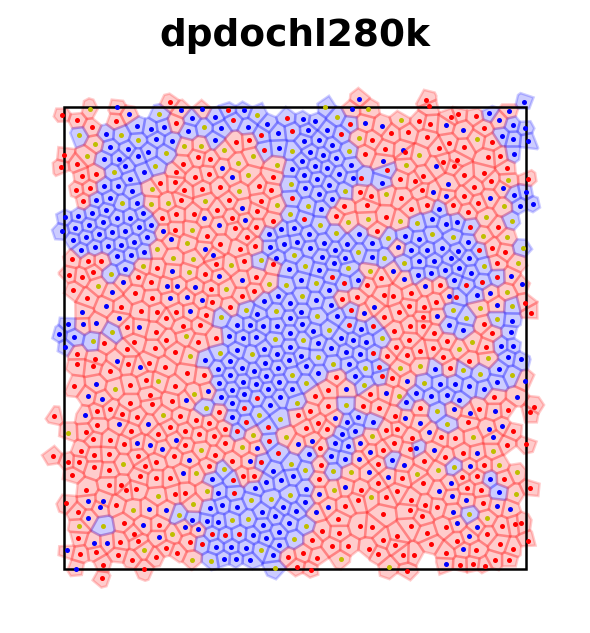

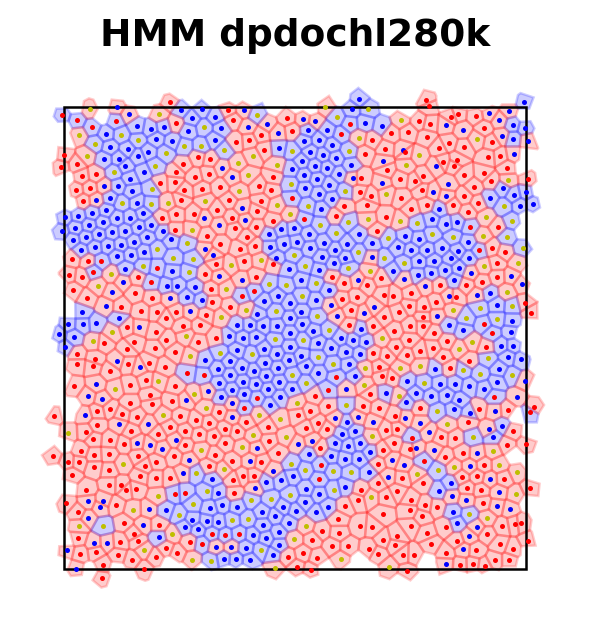

In [22]:
#考虑周期性边界条件的Voronoi tessellation
import MDAnalysis
from scipy.spatial import Voronoi
import numpy as np
import argparse
import math
import matplotlib.pyplot as plt
import matplotlib
from scipy.spatial import Voronoi, ConvexHull
from collections import Counter

interval = 5

# 一些函数###########################################################################################################################
# 函数get_atom分别获得磷脂的两条疏水链的原子
def get_sn(sel_lip, sel_lip_type):
	sel_atom =[]
	for i in range(len(sel_lip)):
		if(sel_lip_type[i] == 'DPPC'):
			tmp_sn1 = sel_lip[i] + ' and (name C32 H2X H2Y C33 H3X H3Y C34 H4X H4Y C35 H5X H5Y C36 H6X H6Y C37 H7X H7Y\
									  C38 H8X H8Y C39 H9X H9Y C310 H10X H10Y C311 H11X H11Y C312 H12X H12Y C313 H13X H13Y\
									  C314 H14X H14Y C315 H15X H15Y C316 H16X H16Y H16Z)'
			tmp_sn2 = sel_lip[i] + ' and (name C22 H2R H2S C23 H3R H3S C24 H4R H4S C25 H5R H5S C26 H6R H6S C27 H7R H7S\
									  C28 H8R H8S C29 H9R H9S C210 H10R H10S C211 H11R H11S C212 H12R H12S C213 H13R H13S\
									  C214 H14R H14S C215 H15R H15S C216 H16R H16S H16T)'
		elif(sel_lip_type[i] == 'DOPC'):
			tmp_sn1 = sel_lip[i] + ' and (name C32 H2X H2Y C33 H3X H3Y C34 H4X H4Y C35 H5X H5Y C36 H6X H6Y C37 H7X H7Y\
									  C38 H8X H8Y C39 H9X C310 H10X C311 H11X H11Y C312 H12X H12Y C313 H13X H13Y\
									  C314 H14X H14Y C315 H15X H15Y C316 H16X H16Y C317 H17X H17Y C318 H18X H18Y H18Z)'
			tmp_sn2 = sel_lip[i] + ' and (name C22 H2R H2S C23 H3R H3S C24 H4R H4S C25 H5R H5S C26 H6R H6S C27 H7R H7S\
									  C28 H8R H8S C29 H9R C210 H10R C211 H11R H11S C212 H12R H12S C213 H13R H13S\
									  C214 H14R H14S C215 H15R H15S C216 H16R H16S C217 H17R H17S C218 H18R H18S H18T)' 
		elif(sel_lip_type[i] == 'POPC'):
			tmp_sn1 = sel_lip[i] + ' and (name C32 H2X H2Y C33 H3X H3Y C34 H4X H4Y C35 H5X H5Y C36 H6X H6Y C37 H7X H7Y\
									  C38 H8X H8Y C39 H9X H9Y C310 H10X H10Y C311 H11X H11Y C312 H12X H12Y C313 H13X H13Y\
									  C314 H14X H14Y C315 H15X H15Y C316 H16X H16Y H16Z)'
			tmp_sn2 = sel_lip[i] + ' and (name C22 H2R H2S C23 H3R H3S C24 H4R H4S C25 H5R H5S C26 H6R H6S C27 H7R H7S\
									  C28 H8R H8S C29 H91 C210 H101 C211 H11R H11S C212 H12R H12S C213 H13R H13S\
									  C214 H14R H14S C215 H15R H15S C216 H16R H16S C217 H17R H17S C218 H18R H18S H18T)'
		elif(sel_lip_type[i] == 'PSM'):
			tmp_sn1 = sel_lip[i] + ' and (name C2F H2F C3F H3F C4F H4F C5F H5F C6F H6F C7F H7F \
									  C8F H8F C9F H9F C10F H10F C11F H11F C12F H12F C13F H13F \
									  C14F H14F C15F H15F C16F H16F C2F H2G C3F H3G C4F H4G C5F H5G C6F H6G C7F H7G \
									   C8F H8G C9F H9G C10F H10G C11F H11G C12F H12G C13F H13G \
									   C14F H14G C15F H15G C16F H16G H16H)'
			tmp_sn2 = sel_lip[i] + ' and (name C6S H6S C7S H7S C8S H8S C9S H9S C10S H10S C11S H11S C12S H12S C13S H13S \
									  C14S H14S C15S H15S C16S H16S C17S H17S C18S H18S C6S H6T C7S H7T C8S H8T C9S H9T C10S H10T C11S H11T C12S H12T C13S H13T \
									  C14S H14T C15S H15T C16S H16T C17S H17T C18S H18T H18U)'
		sel_atom.append(tmp_sn1)
		sel_atom.append(tmp_sn2)
	return sel_atom
def getPolygonArea(points):

	sizep = len(points)
	if sizep<3:
		return 0.0

	area = points[-1][0] * points[0][1] - points[0][0] * points[-1][1]
	for i in range(1, sizep):
		v = i - 1
		area += (points[v][0] * points[i][1])
		area -= (points[i][0] * points[v][1])

	return abs(0.5 * area)
def calculate_lipid_Voronoi_area(points):
	# 计算 Voronoi 分割
	vor = Voronoi(points)
	#按照 points 的顺序对 vor.regions 进行排序
	sorted_regions = [vor.regions[vor.point_region[i]] for i in range(len(points))]
	# 计算每个 Voronoi 区域的面积
	areas = []
	boundary_points = []
	for region in sorted_regions:
		if -1 in region or len(region) == 0:
			# 跳过无效的区域
			areas.append(0)
			boundary_points.append(list(points[i]))
			continue
		# 获取区域的顶点坐标
		vertices = vor.vertices[region]
		# 计算区域的凸包
		area=getPolygonArea(vertices)
		# print('area',area)
		areas.append(area)
	# 检查
	if (len(areas) == len(points)):
		print('                     V_AREAS NUM CORRECT')
	else:
		print('!                    V_AREAS NUM ERROR')

	return areas, vor, sorted_regions, boundary_points
def plot_Voronoi(vor, sorted_regions, points, n_count, box, phase, title_str): #n_count = lip_num*2 + chol_num in one leaflet
	fig, ax = plt.subplots(figsize=(4, 4), dpi=180)
	# 多边形的画图部分
	for i in range(len(sorted_regions)):
		region = sorted_regions[i]
		if -1 in region or len(region) == 0:
			# 跳过无效的区域
			continue
		# 获取区域的顶点坐标
		vertices = vor.vertices[region]
		if(i < len(phase)):
			if(phase[i] == 1):
				ax.fill(*zip(*vertices), alpha=0.2, color='blue')
			elif(phase[i] == 0):
				ax.fill(*zip(*vertices), alpha=0.2, color='red')
		else:
			ax.fill(*zip(*vertices), alpha=0.0, color='white')        #PBC 多边形 

		# if(i<202*2):
		# # if(i<202*2 and i%2==0):
		#     ax.fill(*zip(*vertices), alpha=0.2, color='blue')          #DPPC 多边形
		# elif(i<404*2):
		# # elif(i<404*2 and i%2==0):
		#     #2个多边形融合
		#     ax.fill(*zip(*vertices), alpha=0.2, color='red')           #DOPC 多边形
		# elif(i<n_count):
		#     ax.fill(*zip(*vertices), alpha=0.2, color='orange')        #CHOL 多边形 
		# else:
		#     ax.fill(*zip(*vertices), alpha=0.1, color='grey')        #PBC 多边形 
			# break

	# 点的画图部分
	ax.plot(points[:404, 0], points[:404, 1], 'b.', markersize='2')               # DPPC 2疏水链脂心
	ax.plot(points[404:808, 0], points[404:808, 1], 'r.', markersize='2')     # DOPC 2疏水链脂心
	ax.plot(points[808:n_count, 0], points[808:n_count, 1], 'y.', markersize='2') # chol O3        
	ax.plot(points[n_count:, 0], points[n_count:, 1], '.', alpha=0.0, color='white', markersize='2')            # PBC fake points        # PBC fake points
	# box画图部分                                        
	# 创建一个正方形的顶点坐标
	square = plt.Rectangle((0, 0), box[0], box[1], fill=False)
	# 将正方形添加到坐标轴上
	ax.add_patch(square)
	# 隐藏原始的坐标轴
	ax.axis('off')
	# # 标记刻度和数字（仅显示左下两边的刻度和数字）
	# for i in range(20, 161, 40):
	#     # 左侧刻度及数字
	#     plt.plot([0, 2], [i, i], color='black')  # 刻度线
	#     plt.text(-3, i, str(i), ha='right', va='center')  # 数字标签
	#     # 下方刻度及数字
	#     plt.plot([i, i], [0, 2], color='black')  # 刻度线
	#     plt.text(i, -3, str(i), ha='center', va='top')  # 数字标签
	
	# ax.axis('off')

	x_min = 0-0.1*box[0]
	x_max = 1.1*box[0]
	y_min = 0-0.1*box[1]
	y_max = 1.1*box[1]
	plt.xlim(x_min, x_max)
	plt.ylim(y_min, y_max)
	plt.title(title_str, fontsize= 15, fontweight='bold')
	plt.gca().set_aspect('equal')
	plt.savefig(
	'/data/gulab/yzdai/data4/phase_identification/plot/output/voronoi/'+title_str+'.png',        # 文件名
	dpi=350,             # 分辨率
	format='png',        # 文件格式
	bbox_inches='tight', # 自动调整边界框
	pad_inches=0.0,      # 边界填充
	# facecolor='white',   # 背景颜色
	# edgecolor='black',   # 边缘颜色
	transparent=True,   # 是否透明背景
	# metadata={'Author': 'Your Name'}  # 元数据
	)       
def simulate_PBC(points_leaflet, box):  # 改成 points leaflet判断并移动
	PBC_points = []
	x_min = 0-0.1*box[0]
	x_max = 1.1*box[0]
	y_min = 0-0.1*box[1]
	y_max = 1.1*box[1]
	for i in range(len(points_leaflet)):
		# 左移 
		if(points_leaflet[i, 0] > box[0]*0.9):
			x = points_leaflet[i, 0] - box[0]
			y = points_leaflet[i, 1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])
		# 右移 
		if(points_leaflet[i, 0] < box[0]*0.1):
			x = points_leaflet[i, 0] + box[0]
			y = points_leaflet[i, 1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])
		# 上移 
		if(points_leaflet[i, 1] < box[1]*0.1):
			x = points_leaflet[i, 0]
			y = points_leaflet[i, 1] + box[1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])            
		# 下移 
		if(points_leaflet[i, 1] > box[1]*0.9):
			x = points_leaflet[i, 0]
			y = points_leaflet[i, 1] - box[1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])            
		# 左上移  
		if(points_leaflet[i, 0] > box[0]*0.9 and points_leaflet[i, 1] < box[1]*0.1):
			x = points_leaflet[i, 0] - box[0]
			y = points_leaflet[i, 1] + box[1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])            
		# 左下移
		if(points_leaflet[i, 0] > box[0]*0.9 and points_leaflet[i, 1] > box[1]*0.9):
			x = points_leaflet[i, 0] - box[0]
			y = points_leaflet[i, 1] - box[1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])            
		# 右上移
		if(points_leaflet[i, 0] < box[0]*0.1 and points_leaflet[i, 1] < box[1]*0.1):
			x = points_leaflet[i, 0] + box[0]
			y = points_leaflet[i, 1] + box[1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])           
		# 右下移
		if(points_leaflet[i, 0] < box[0]*0.1 and points_leaflet[i, 1] > box[1]*0.9):
			x = points_leaflet[i, 0] + box[0]
			y = points_leaflet[i, 1] - box[1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])           
	PBC_points = np.array(PBC_points)
	return PBC_points
# 这里开始定义一个大函数，输入是每个片层选择的所有原子 包括chol
def leaflet_Vor(sel_atom_leaflet, count_leaflet_lip, box):
	# 获得所有Voronoi点的坐标
	points_leaflet = []
	for i in range(0, len(sel_atom_leaflet)):
		point = u.select_atoms(sel_atom_leaflet[i]).center_of_mass()
		points_leaflet.append(list(point[0:2]))
	points_leaflet = np.array(points_leaflet)
	# 记有效点数为 n_count == lip_num*2 + chol_num
	n_count = len(points_leaflet)

	# 对边界点进行8次处理
	PBC_points = simulate_PBC(points_leaflet, box)
	# 获得 points_with_PBC
	points_with_PBC = np.array(list(points_leaflet) + list(PBC_points))  # 直接在这里调函数simulate pbc

	print('PBC_points:\t' + str(len(PBC_points)) + '\tpoints_with_PBC:\t' + str(len(points_with_PBC)))
	# 对points_with_PBC进行Voronio tessellation 
	areas, vor, sorted_regions, _boundary_points = calculate_lipid_Voronoi_area(points_with_PBC)

	areas = areas[:n_count] #这里是每个非PBC点的面积，接下来我们要获得每个脂质的面积
	chol_area = areas[-count_leaflet_lip*2:]
	lip_area = []
	for i in range(0,count_leaflet_lip*2,2):
		if(areas[i]==0 or areas[i+1]==0):
			print('!                    FINAL AREAS ZERO ERROR')
			break
		else:
			tmp = areas[i] + areas[i+1]
			lip_area.append(tmp)
	print('lip_area:\t' + str(len(lip_area)))
	return lip_area, chol_area, vor, sorted_regions, points_with_PBC
#识别共享边，确定相边界顶点，相边界索引
def share_boundary(vor,sorted_regions,tail_phase):
	i=0
	boundary_index=[]
	#选定一个区域作为中心区域
	m=0 
	# boundary_vertices=np.zeros((1,2))
	for i in range ( len(sorted_regions)):
		region=sorted_regions[i]   
		region_adjacent=[]
		region_adjacent_index=[]
		j=0
		#确定中心区域旁的相邻区域
		for tmp in sorted_regions:
			if len( list(set(region) & set(tmp)))>=2 and len( list(set(region) & set(tmp)))<len(region): #确定相邻区域，不包含中心区域
				share_vertices =  list(set(region) & set(tmp))
				region_adjacent.append(tmp)       
				region_adjacent_index.append(j)   #确定相邻区域的索引，不包含中心区域 
			j+=1
		#确定边界相区域1
		# share_vertices_num=0
		# for l in range(len(region_adjacent_index)):
		#     if len( list(set(region_adjacent[l]) & set(sorted_regions[i])))>0:
		#         # print( list(set(region_adjacent[l]) & set(sorted_regions[i])))
		#         share_vertices_num+=1
		#     if tail_phase[region_adjacent_index[l]]!=tail_phase[i] and share_vertices_num<3: #确定相邻区域与中心区域相态是否相同，若不同则中心区域为边界相区域
		#                                     #由于遍历所有区域，因此只需要判断中心区域是否为边界相区域，从而可得所有边界相区域
		#         boundary_index.append(i) 
		#         break
		#确定边界相区域2
		phase0_num=0
		phase1_num=0
		b_mol_if='no'
		for l in range(len(region_adjacent_index)):
			if tail_phase[region_adjacent_index[l]]==0 :
				phase0_num+=1
			else:
				# print( list(set(region_adjacent[l]) & set(sorted_regions[i])))
				phase1_num+=1
		for l in range(len(region_adjacent_index)):
			if tail_phase[region_adjacent_index[l]]!=tail_phase[i]:
				b_mol_if='yes'
				break
		if b_mol_if=='yes' and not \
		(phase0_num>len(region_adjacent_index)-2 or  phase1_num>len(region_adjacent_index)-2): #确定相邻区域与中心区域相态是否相同，若不同则中心区域为边界相区域
											#由于遍历所有区域，因此只需要判断中心区域是否为边界相区域，从而可得所有边界相区域
			boundary_index.append(i)           
		#确定边界点
		for k in region_adjacent_index:
			if tail_phase[k]!=tail_phase[i]:                     
				vertices_around =vor.vertices[sorted_regions[k]] #确定相邻区域的顶点
				vertices_center =vor.vertices[sorted_regions[i]] #确定中心区域的顶点
				# print(vor.vertices[sorted_regions[k]])
				# print(vor.vertices[sorted_regions[i]])
				for tmp_c in vertices_center:                    #确定与中心区域相同的顶点，即边界点
					for tmp_a in vertices_around:
						if tmp_c[0]==tmp_a[0] and tmp_c[1]==tmp_a[1]:
							if m==0:
								boundary_vertices=tmp_c                                   
								m+=1
							else: boundary_vertices=np.concatenate((boundary_vertices,tmp_c)) #将所有边界点结合到一起,相邻两个为共享边
				
	boundary_vertices=boundary_vertices.reshape(int(len(boundary_vertices)/2),2)

	return boundary_vertices,boundary_index
def area_phase(sorted_regions,tail_phase,boundary_vertices,areas_all):
	i=0
	area_phase0=[]
	area_phase1=[]
	boundary_index=[]
	#确定区域相态
	for i in range ( len(sorted_regions)):
		j=0
		if tail_phase[i]==0:
			area_phase0.append(areas_all[i])
		else:
			area_phase1.append(areas_all[i])
	area_phase0_sum=sum(area_phase0)
	area_phase1_sum=sum(area_phase1)
	length_all=[]
	
	for i in range(0,boundary_vertices.shape[0],2):
		length = np.linalg.norm(boundary_vertices[i+1] - boundary_vertices[i])
		length_all.append(length)
	length_sum=sum(length_all)
	print('area_sum;','area_phase0_sum;','area_phase1_sum;','length_sum;','A_0/L')
	print(np.sum(areas_all),area_phase0_sum,area_phase1_sum,length_sum,area_phase0_sum/length_sum)
	R_0=area_phase0_sum/length_sum
	return np.sum(areas_all),area_phase0_sum,area_phase1_sum,length_sum,R_0
# MAIN###########################################################################################################################
lip_leaflet_raw = np.loadtxt(fn_leaflet)[:,1:]

# 获得单片层lip type without CHOL
sel_lip_type_upper = ['DPPC' for x in range(202)] + ['DOPC' for x in range(202)] 
sel_lip_type_lower = ['DPPC' for x in range(202)] + ['DOPC' for x in range(202)] 
# 获得上片层磷脂的resid
sel_lip_upper = list(range(1,405)) 
for i in range(0,len(sel_lip_upper)):
	sel_lip_upper[i] = 'resid '+str(sel_lip_upper[i])
# 获得下片层磷脂的resid
sel_lip_lower = list(range(577,981))
for i in range(0,len(sel_lip_lower)):
	sel_lip_lower[i] = 'resid '+str(sel_lip_lower[i])

all_chol_id = [int(x) for x in range(405,577)] + [int(x) for x in range(981,1153)]


u = MDAnalysis.Universe(pdb, trj)
for ts in u.trajectory[b:e:interval]:   #最后5ns的结果
	# 载入phase信息
	atom_phase_all = list(np.loadtxt(atom_phase_fn)[-1,1:])
	HMMphase = np.loadtxt(HMM_phase_fn)[:,1:]
	if (sum(HMMphase[:,0] == 0) > sum(HMMphase[:,0] == 1)):
		HMMphase = 1 - HMMphase
	HMM_phase_all = list(HMMphase[-1,:])   ####

	chl_resname = 'CHL1'
	fn_leaflets = lip_leaflet_raw[b:e, :]
	most_common_leaflet_tag = [Counter(column).most_common(1)[0][0] for column in zip(*fn_leaflets)]
	sel_upper_chol=[]; sel_lower_chol=[]
	atom_phase_upper_chol=[]; atom_phase_lower_chol=[]
	HMM_phase_upper_chol=[]; HMM_phase_lower_chol=[]
	for chol_id in all_chol_id:
		index = chol_id - 1
		leaflet_tag = most_common_leaflet_tag[index]
		atom_phase_tag = atom_phase_all[index]
		HMM_phase_tag = HMM_phase_all[index]
		if leaflet_tag == 0:
			sel_upper_chol.append(chol_id)
			atom_phase_upper_chol.append(atom_phase_tag)
			HMM_phase_upper_chol.append(HMM_phase_tag)
		else:
			sel_lower_chol.append(chol_id)
			atom_phase_lower_chol.append(atom_phase_tag)
			HMM_phase_lower_chol.append(HMM_phase_tag)
	atom_phase_upper_lip = [item for item in atom_phase_all[:404] for _ in range(2)]
	atom_phase_lower_lip = [item for item in atom_phase_all[576:980] for _ in range(2)]
	HMM_phase_upper_lip = [item for item in HMM_phase_all[:404] for _ in range(2)]
	HMM_phase_lower_lip = [item for item in HMM_phase_all[576:980] for _ in range(2)]
	atom_phase_of_points_up = atom_phase_upper_lip + atom_phase_upper_chol
	atom_phase_of_points_low = atom_phase_lower_lip + atom_phase_lower_chol
	HMM_phase_of_points_up = HMM_phase_upper_lip + HMM_phase_upper_chol
	HMM_phase_of_points_low = HMM_phase_lower_lip + HMM_phase_lower_chol

	count_upper_chol = len(sel_upper_chol)
	count_lower_chol = len(sel_lower_chol)
	# 取上下片层磷脂疏水链原子
	sel_atom_upper = get_sn(sel_lip_upper, sel_lip_type_upper)
	sel_atom_lower = get_sn(sel_lip_lower, sel_lip_type_lower)

	for i in range(count_upper_chol):
		tmp = 'resname ' + chl_resname + ' and resid ' + str(sel_upper_chol[i]) + ' '# + 'and name ' + chl_atomname
		sel_atom_upper.append(tmp)
	for i in range(count_lower_chol):
		tmp = 'resname ' + chl_resname + ' and resid ' + str(sel_lower_chol[i]) + ' '# + ' and name ' + chl_atomname
		sel_atom_lower.append(tmp)
	print('upper atoms:\t' + str(len(sel_atom_upper)) + '\tlower atoms:\t' + str(len(sel_atom_lower)))

	count_leaflet_lip = 404  # 不同体系需要改
	box = ts.dimensions[:3]

	n_count_up =  count_leaflet_lip*2 + count_upper_chol #points的数量。每个脂质2个point,每个chol一个point
	n_count_low = count_leaflet_lip*2 + count_lower_chol
for ts in u.trajectory[b:b+1]: 
	print('upper--------------------------------------------------')
	lip_area_up, chol_area_up, vor_up, sorted_regions_up, points_all_up = leaflet_Vor(sel_atom_upper, count_leaflet_lip, box)
	print('lower--------------------------------------------------')
	lip_area_low, chol_area_low, vor_low, sorted_regions_low, points_all_low = leaflet_Vor(sel_atom_lower, count_leaflet_lip, box)
	print('-------------------------------------------------------')
	print('n_count_up:\t' + str(n_count_up) + '\tn_count_low:\t' + str(n_count_low))
	print('points_all_up:\t' + str(len(points_all_up)) + '\tpoints_all_low:\t' + str(len(points_all_low)))

	# visualization atom density
	plot_Voronoi(vor_up, sorted_regions_up, points_all_up, n_count_up, box, atom_phase_of_points_up, title_str = sys)
	plot_Voronoi(vor_up, sorted_regions_up, points_all_up, n_count_up, box, HMM_phase_of_points_up, title_str = "HMM " + sys)
	

### compare

In [9]:
#考虑周期性边界条件的Voronoi tessellation
import MDAnalysis
from scipy.spatial import Voronoi
import numpy as np
import argparse
import math
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, ConvexHull
from collections import Counter

b = 8995
e = 9000
# b = 8545
# e = 8550
interval = 5
# out = '/home/yzdai/Project2/dodpchol_FeatureCal/tmp.xvg'
# outf = open(out, 'w')

# 一些函数###########################################################################################################################
# 函数get_atom分别获得磷脂的两条疏水链的原子
def get_sn(sel_lip, sel_lip_type):
	sel_atom =[]
	for i in range(len(sel_lip)):
		if(sel_lip_type[i] == 'DPPC'):
			tmp_sn1 = sel_lip[i] + ' and (name C32 H2X H2Y C33 H3X H3Y C34 H4X H4Y C35 H5X H5Y C36 H6X H6Y C37 H7X H7Y\
									  C38 H8X H8Y C39 H9X H9Y C310 H10X H10Y C311 H11X H11Y C312 H12X H12Y C313 H13X H13Y\
									  C314 H14X H14Y C315 H15X H15Y C316 H16X H16Y H16Z)'
			tmp_sn2 = sel_lip[i] + ' and (name C22 H2R H2S C23 H3R H3S C24 H4R H4S C25 H5R H5S C26 H6R H6S C27 H7R H7S\
									  C28 H8R H8S C29 H9R H9S C210 H10R H10S C211 H11R H11S C212 H12R H12S C213 H13R H13S\
									  C214 H14R H14S C215 H15R H15S C216 H16R H16S H16T)'
		elif(sel_lip_type[i] == 'DOPC'):
			tmp_sn1 = sel_lip[i] + ' and (name C32 H2X H2Y C33 H3X H3Y C34 H4X H4Y C35 H5X H5Y C36 H6X H6Y C37 H7X H7Y\
									  C38 H8X H8Y C39 H9X C310 H10X C311 H11X H11Y C312 H12X H12Y C313 H13X H13Y\
									  C314 H14X H14Y C315 H15X H15Y C316 H16X H16Y C317 H17X H17Y C318 H18X H18Y H18Z)'
			tmp_sn2 = sel_lip[i] + ' and (name C22 H2R H2S C23 H3R H3S C24 H4R H4S C25 H5R H5S C26 H6R H6S C27 H7R H7S\
									  C28 H8R H8S C29 H9R C210 H10R C211 H11R H11S C212 H12R H12S C213 H13R H13S\
									  C214 H14R H14S C215 H15R H15S C216 H16R H16S C217 H17R H17S C218 H18R H18S H18T)' 
		elif(sel_lip_type[i] == 'POPC'):
			tmp_sn1 = sel_lip[i] + ' and (name C32 H2X H2Y C33 H3X H3Y C34 H4X H4Y C35 H5X H5Y C36 H6X H6Y C37 H7X H7Y\
									  C38 H8X H8Y C39 H9X H9Y C310 H10X H10Y C311 H11X H11Y C312 H12X H12Y C313 H13X H13Y\
									  C314 H14X H14Y C315 H15X H15Y C316 H16X H16Y H16Z)'
			tmp_sn2 = sel_lip[i] + ' and (name C22 H2R H2S C23 H3R H3S C24 H4R H4S C25 H5R H5S C26 H6R H6S C27 H7R H7S\
									  C28 H8R H8S C29 H91 C210 H101 C211 H11R H11S C212 H12R H12S C213 H13R H13S\
									  C214 H14R H14S C215 H15R H15S C216 H16R H16S C217 H17R H17S C218 H18R H18S H18T)'
		elif(sel_lip_type[i] == 'PSM'):
			tmp_sn1 = sel_lip[i] + ' and (name C2F H2F C3F H3F C4F H4F C5F H5F C6F H6F C7F H7F \
									  C8F H8F C9F H9F C10F H10F C11F H11F C12F H12F C13F H13F \
									  C14F H14F C15F H15F C16F H16F C2F H2G C3F H3G C4F H4G C5F H5G C6F H6G C7F H7G \
									   C8F H8G C9F H9G C10F H10G C11F H11G C12F H12G C13F H13G \
									   C14F H14G C15F H15G C16F H16G H16H)'
			tmp_sn2 = sel_lip[i] + ' and (name C6S H6S C7S H7S C8S H8S C9S H9S C10S H10S C11S H11S C12S H12S C13S H13S \
									  C14S H14S C15S H15S C16S H16S C17S H17S C18S H18S C6S H6T C7S H7T C8S H8T C9S H9T C10S H10T C11S H11T C12S H12T C13S H13T \
									  C14S H14T C15S H15T C16S H16T C17S H17T C18S H18T H18U)'
		sel_atom.append(tmp_sn1)
		sel_atom.append(tmp_sn2)
	return sel_atom
def getPolygonArea(points):

	sizep = len(points)
	if sizep<3:
		return 0.0

	area = points[-1][0] * points[0][1] - points[0][0] * points[-1][1]
	for i in range(1, sizep):
		v = i - 1
		area += (points[v][0] * points[i][1])
		area -= (points[i][0] * points[v][1])

	return abs(0.5 * area)
def calculate_lipid_Voronoi_area(points):
	# 计算 Voronoi 分割
	vor = Voronoi(points)
	#按照 points 的顺序对 vor.regions 进行排序
	sorted_regions = [vor.regions[vor.point_region[i]] for i in range(len(points))]
	# 计算每个 Voronoi 区域的面积
	areas = []
	boundary_points = []
	for region in sorted_regions:
		if -1 in region or len(region) == 0:
			# 跳过无效的区域
			areas.append(0)
			boundary_points.append(list(points[i]))
			continue
		# 获取区域的顶点坐标
		vertices = vor.vertices[region]
		# 计算区域的凸包
		area=getPolygonArea(vertices)
		# print('area',area)
		areas.append(area)
	# 检查
	if (len(areas) == len(points)):
		print('                     V_AREAS NUM CORRECT')
	else:
		print('!                    V_AREAS NUM ERROR')

	return areas, vor, sorted_regions, boundary_points
def plot_Voronoi(ax, vor, sorted_regions, points, n_count, box, phase, title_str): #n_count = lip_num*2 + chol_num in one leaflet
	# fig, ax = plt.subplots(figsize=(4, 4), dpi=180)
	# 多边形的画图部分
	for i in range(len(sorted_regions)):
		region = sorted_regions[i]
		if -1 in region or len(region) == 0:
			# 跳过无效的区域
			continue
		# 获取区域的顶点坐标
		vertices = vor.vertices[region]
		if(i < len(phase)):
			if(phase[i] == 1):
				ax.fill(*zip(*vertices), alpha=0.2, color='blue')
			elif(phase[i] == 0):
				ax.fill(*zip(*vertices), alpha=0.2, color='red')
		else:
			ax.fill(*zip(*vertices), alpha=0.0, color='white')        #PBC 多边形 

		# if(i<202*2):
		# # if(i<202*2 and i%2==0):
		#     ax.fill(*zip(*vertices), alpha=0.2, color='blue')          #DPPC 多边形
		# elif(i<404*2):
		# # elif(i<404*2 and i%2==0):
		#     #2个多边形融合
		#     ax.fill(*zip(*vertices), alpha=0.2, color='red')           #DOPC 多边形
		# elif(i<n_count):
		#     ax.fill(*zip(*vertices), alpha=0.2, color='orange')        #CHOL 多边形 
		# else:
		#     ax.fill(*zip(*vertices), alpha=0.1, color='grey')        #PBC 多边形 
			# break

	# 点的画图部分
	ax.plot(points[:404, 0], points[:404, 1], 'b.', markersize='2')               # DPPC 2疏水链脂心
	ax.plot(points[404:808, 0], points[404:808, 1], 'r.', markersize='2')     # DOPC 2疏水链脂心
	ax.plot(points[808:n_count, 0], points[808:n_count, 1], 'y.', markersize='2') # chol O3        
	ax.plot(points[n_count:, 0], points[n_count:, 1], '.', alpha=0.0, color='white', markersize='2')            # PBC fake points
	# box画图部分                                        
	# 创建一个正方形的顶点坐标
	square = plt.Rectangle((0, 0), box[0], box[1], fill=False)
	# 将正方形添加到坐标轴上
	ax.add_patch(square)
	# 隐藏原始的坐标轴
	ax.axis('off')
	# 标记刻度和数字（仅显示左下两边的刻度和数字）
	for i in range(20, 161, 40):
		# 左侧刻度及数字
		ax.plot([0, 2], [i, i], color='black')  # 刻度线
		plt.text(-3, i, str(i), ha='right', va='center')  # 数字标签
		# 下方刻度及数字
		ax.plot([i, i], [0, 2], color='black')  # 刻度线
		ax.text(i, -3, str(i), ha='center', va='top')  # 数字标签
	
	x_min = 0-0.1*box[0]
	x_max = 1.1*box[0]
	y_min = 0-0.1*box[1]
	y_max = 1.1*box[1]
	ax.set_xlim(x_min, x_max)
	ax.set_ylim(y_min, y_max)
	# plt.title(title_str, fontsize= 15, fontweight='bold')
	# plt.gca().set_aspect('equal')                 ################
	return ax
	# plt.savefig(
	# '/data/gulab/yzdai/data4/atomdensity/plot_data/out/voronoi/'+title_str+'-trans.png',        # 文件名
	# dpi=350,             # 分辨率
	# format='png',        # 文件格式
	# bbox_inches='tight', # 自动调整边界框
	# pad_inches=0.0,      # 边界填充
	# # facecolor='white',   # 背景颜色
	# # edgecolor='black',   # 边缘颜色
	# transparent=True,   # 是否透明背景
	# # metadata={'Author': 'Your Name'}  # 元数据
	# )      
def simulate_PBC(points_leaflet, box):  # 改成 points leaflet判断并移动
	PBC_points = []
	x_min = 0-0.1*box[0]
	x_max = 1.1*box[0]
	y_min = 0-0.1*box[1]
	y_max = 1.1*box[1]
	for i in range(len(points_leaflet)):
		# 左移 
		if(points_leaflet[i, 0] > box[0]*0.9):
			x = points_leaflet[i, 0] - box[0]
			y = points_leaflet[i, 1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])
		# 右移 
		if(points_leaflet[i, 0] < box[0]*0.1):
			x = points_leaflet[i, 0] + box[0]
			y = points_leaflet[i, 1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])
		# 上移 
		if(points_leaflet[i, 1] < box[1]*0.1):
			x = points_leaflet[i, 0]
			y = points_leaflet[i, 1] + box[1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])            
		# 下移 
		if(points_leaflet[i, 1] > box[1]*0.9):
			x = points_leaflet[i, 0]
			y = points_leaflet[i, 1] - box[1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])            
		# 左上移  
		if(points_leaflet[i, 0] > box[0]*0.9 and points_leaflet[i, 1] < box[1]*0.1):
			x = points_leaflet[i, 0] - box[0]
			y = points_leaflet[i, 1] + box[1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])            
		# 左下移
		if(points_leaflet[i, 0] > box[0]*0.9 and points_leaflet[i, 1] > box[1]*0.9):
			x = points_leaflet[i, 0] - box[0]
			y = points_leaflet[i, 1] - box[1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])            
		# 右上移
		if(points_leaflet[i, 0] < box[0]*0.1 and points_leaflet[i, 1] < box[1]*0.1):
			x = points_leaflet[i, 0] + box[0]
			y = points_leaflet[i, 1] + box[1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])           
		# 右下移
		if(points_leaflet[i, 0] < box[0]*0.1 and points_leaflet[i, 1] > box[1]*0.9):
			x = points_leaflet[i, 0] + box[0]
			y = points_leaflet[i, 1] - box[1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])           
	PBC_points = np.array(PBC_points)
	return PBC_points
# 这里开始定义一个大函数，输入是每个片层选择的所有原子 包括chol
def leaflet_Vor(sel_atom_leaflet, count_leaflet_lip, box):
	# 获得所有Voronoi点的坐标
	points_leaflet = []
	for i in range(0, len(sel_atom_leaflet)):
		point = u.select_atoms(sel_atom_leaflet[i]).center_of_mass()
		points_leaflet.append(list(point[0:2]))
	points_leaflet = np.array(points_leaflet)
	# 记有效点数为 n_count == lip_num*2 + chol_num
	n_count = len(points_leaflet)

	# 对边界点进行8次处理
	PBC_points = simulate_PBC(points_leaflet, box)
	# 获得 points_with_PBC
	points_with_PBC = np.array(list(points_leaflet) + list(PBC_points))  # 直接在这里调函数simulate pbc

	print('PBC_points:\t' + str(len(PBC_points)) + '\tpoints_with_PBC:\t' + str(len(points_with_PBC)))
	# 对points_with_PBC进行Voronio tessellation 
	areas, vor, sorted_regions, _boundary_points = calculate_lipid_Voronoi_area(points_with_PBC)

	areas = areas[:n_count] #这里是每个非PBC点的面积，接下来我们要获得每个脂质的面积
	chol_area = areas[-count_leaflet_lip*2:]
	lip_area = []
	for i in range(0,count_leaflet_lip*2,2):
		if(areas[i]==0 or areas[i+1]==0):
			print('!                    FINAL AREAS ZERO ERROR')
			break
		else:
			tmp = areas[i] + areas[i+1]
			lip_area.append(tmp)
	print('lip_area:\t' + str(len(lip_area)))
	return lip_area, chol_area, vor, sorted_regions, points_with_PBC
#识别共享边，确定相边界顶点，相边界索引
def share_boundary(vor,sorted_regions,tail_phase):
	i=0
	boundary_index=[]
	#选定一个区域作为中心区域
	m=0 
	# boundary_vertices=np.zeros((1,2))
	for i in range ( len(sorted_regions)):
		region=sorted_regions[i]   
		region_adjacent=[]
		region_adjacent_index=[]
		j=0
		#确定中心区域旁的相邻区域
		for tmp in sorted_regions:
			if len( list(set(region) & set(tmp)))>=2 and len( list(set(region) & set(tmp)))<len(region): #确定相邻区域，不包含中心区域
				share_vertices =  list(set(region) & set(tmp))
				region_adjacent.append(tmp)       
				region_adjacent_index.append(j)   #确定相邻区域的索引，不包含中心区域 
			j+=1
		#确定边界相区域1
		# share_vertices_num=0
		# for l in range(len(region_adjacent_index)):
		#     if len( list(set(region_adjacent[l]) & set(sorted_regions[i])))>0:
		#         # print( list(set(region_adjacent[l]) & set(sorted_regions[i])))
		#         share_vertices_num+=1
		#     if tail_phase[region_adjacent_index[l]]!=tail_phase[i] and share_vertices_num<3: #确定相邻区域与中心区域相态是否相同，若不同则中心区域为边界相区域
		#                                     #由于遍历所有区域，因此只需要判断中心区域是否为边界相区域，从而可得所有边界相区域
		#         boundary_index.append(i) 
		#         break
		#确定边界相区域2
		phase0_num=0
		phase1_num=0
		b_mol_if='no'
		for l in range(len(region_adjacent_index)):
			if tail_phase[region_adjacent_index[l]]==0 :
				phase0_num+=1
			else:
				# print( list(set(region_adjacent[l]) & set(sorted_regions[i])))
				phase1_num+=1
		for l in range(len(region_adjacent_index)):
			if tail_phase[region_adjacent_index[l]]!=tail_phase[i]:
				b_mol_if='yes'
				break
		if b_mol_if=='yes' and not \
		(phase0_num>len(region_adjacent_index)-2 or  phase1_num>len(region_adjacent_index)-2): #确定相邻区域与中心区域相态是否相同，若不同则中心区域为边界相区域
											#由于遍历所有区域，因此只需要判断中心区域是否为边界相区域，从而可得所有边界相区域
			boundary_index.append(i)           
		#确定边界点
		for k in region_adjacent_index:
			if tail_phase[k]!=tail_phase[i]:                     
				vertices_around =vor.vertices[sorted_regions[k]] #确定相邻区域的顶点
				vertices_center =vor.vertices[sorted_regions[i]] #确定中心区域的顶点
				# print(vor.vertices[sorted_regions[k]])
				# print(vor.vertices[sorted_regions[i]])
				for tmp_c in vertices_center:                    #确定与中心区域相同的顶点，即边界点
					for tmp_a in vertices_around:
						if tmp_c[0]==tmp_a[0] and tmp_c[1]==tmp_a[1]:
							if m==0:
								boundary_vertices=tmp_c                                   
								m+=1
							else: boundary_vertices=np.concatenate((boundary_vertices,tmp_c)) #将所有边界点结合到一起,相邻两个为共享边
				
	boundary_vertices=boundary_vertices.reshape(int(len(boundary_vertices)/2),2)

	return boundary_vertices,boundary_index
def area_phase(sorted_regions,tail_phase,boundary_vertices,areas_all):
	i=0
	area_phase0=[]
	area_phase1=[]
	boundary_index=[]
	#确定区域相态
	for i in range ( len(sorted_regions)):
		j=0
		if tail_phase[i]==0:
			area_phase0.append(areas_all[i])
		else:
			area_phase1.append(areas_all[i])
	area_phase0_sum=sum(area_phase0)
	area_phase1_sum=sum(area_phase1)
	length_all=[]
	
	for i in range(0,boundary_vertices.shape[0],2):
		length = np.linalg.norm(boundary_vertices[i+1] - boundary_vertices[i])
		length_all.append(length)
	length_sum=sum(length_all)
	print('area_sum;','area_phase0_sum;','area_phase1_sum;','length_sum;','A_0/L')
	print(np.sum(areas_all),area_phase0_sum,area_phase1_sum,length_sum,area_phase0_sum/length_sum)
	R_0=area_phase0_sum/length_sum
	return np.sum(areas_all),area_phase0_sum,area_phase1_sum,length_sum,R_0
# MAIN###########################################################################################################################
lip_leaflet_raw = np.loadtxt(fn_leaflet)[:,1:]
# 获得单片层lip type without CHOL
sel_lip_type_upper = ['DPPC' for x in range(202)] + ['DOPC' for x in range(202)] 
sel_lip_type_lower = ['DPPC' for x in range(202)] + ['DOPC' for x in range(202)] 
# 获得上片层磷脂的resid
sel_lip_upper = list(range(1,405)) 
for i in range(0,len(sel_lip_upper)):
	sel_lip_upper[i] = 'resid '+str(sel_lip_upper[i])
# 获得下片层磷脂的resid
sel_lip_lower = list(range(577,981))
for i in range(0,len(sel_lip_lower)):
	sel_lip_lower[i] = 'resid '+str(sel_lip_lower[i])

all_chol_id = [int(x) for x in range(405,577)] + [int(x) for x in range(981,1153)]

u = MDAnalysis.Universe(pdb, trj)
for ts in u.trajectory[b:e:interval]:
	# 载入phase信息
	atom_phase_all = list(np.loadtxt(atom_phase_fn)[-1,1:])
	HMM_phase_all = list(np.loadtxt(HMM_phase_fn)[-1,1:])
	# atom_phase_all = list(np.loadtxt(atom_phase_fn)[109,1:])
	# HMM_phase_all = list(np.loadtxt(HMM_phase_fn)[109,1:])
	chl_resname = 'CHL1'
	fn_leaflets = lip_leaflet_raw[b:e, :]
	most_common_leaflet_tag = [Counter(column).most_common(1)[0][0] for column in zip(*fn_leaflets)]
	sel_upper_chol=[]; sel_lower_chol=[]
	atom_phase_upper_chol=[]; atom_phase_lower_chol=[]
	HMM_phase_upper_chol=[]; HMM_phase_lower_chol=[]
	for chol_id in all_chol_id:
		index = chol_id - 1
		leaflet_tag = most_common_leaflet_tag[index]
		atom_phase_tag = atom_phase_all[index]
		HMM_phase_tag = HMM_phase_all[index]
		if leaflet_tag == 0:
			sel_upper_chol.append(chol_id)
			atom_phase_upper_chol.append(atom_phase_tag)
			HMM_phase_upper_chol.append(HMM_phase_tag)
		else:
			sel_lower_chol.append(chol_id)
			atom_phase_lower_chol.append(atom_phase_tag)
			HMM_phase_lower_chol.append(HMM_phase_tag)
	atom_phase_upper_lip = [item for item in atom_phase_all[:404] for _ in range(2)]
	atom_phase_lower_lip = [item for item in atom_phase_all[576:980] for _ in range(2)]
	HMM_phase_upper_lip = [item for item in HMM_phase_all[:404] for _ in range(2)]
	HMM_phase_lower_lip = [item for item in HMM_phase_all[576:980] for _ in range(2)]
	atom_phase_of_points_up = atom_phase_upper_lip + atom_phase_upper_chol
	atom_phase_of_points_low = atom_phase_lower_lip + atom_phase_lower_chol
	HMM_phase_of_points_up = HMM_phase_upper_lip + HMM_phase_upper_chol
	HMM_phase_of_points_low = HMM_phase_lower_lip + HMM_phase_lower_chol

	count_upper_chol = len(sel_upper_chol)
	count_lower_chol = len(sel_lower_chol)
	# 取上下片层磷脂疏水链原子
	sel_atom_upper = get_sn(sel_lip_upper, sel_lip_type_upper)
	sel_atom_lower = get_sn(sel_lip_lower, sel_lip_type_lower)

	for i in range(count_upper_chol):
		tmp = 'resname ' + chl_resname + ' and resid ' + str(sel_upper_chol[i]) + ' '# + 'and name ' + chl_atomname
		sel_atom_upper.append(tmp)
	for i in range(count_lower_chol):
		tmp = 'resname ' + chl_resname + ' and resid ' + str(sel_lower_chol[i]) + ' '# + ' and name ' + chl_atomname
		sel_atom_lower.append(tmp)
	print('upper atoms:\t' + str(len(sel_atom_upper)) + '\tlower atoms:\t' + str(len(sel_atom_lower)))

	count_leaflet_lip = 404  # 不同体系需要改
	box = ts.dimensions[:3]

	n_count_up =  count_leaflet_lip*2 + count_upper_chol #points的数量。每个脂质2个point,每个chol一个point
	n_count_low = count_leaflet_lip*2 + count_lower_chol
	print('upper--------------------------------------------------')
	lip_area_up, chol_area_up, vor_up, sorted_regions_up, points_all_up = leaflet_Vor(sel_atom_upper, count_leaflet_lip, box)
	print('lower--------------------------------------------------')
	lip_area_low, chol_area_low, vor_low, sorted_regions_low, points_all_low = leaflet_Vor(sel_atom_lower, count_leaflet_lip, box)
	print('-------------------------------------------------------')
	print('n_count_up:\t' + str(n_count_up) + '\tn_count_low:\t' + str(n_count_low))
	print('points_all_up:\t' + str(len(points_all_up)) + '\tpoints_all_low:\t' + str(len(points_all_low)))

	# visualization atom density
	# plot_Voronoi(vor_up, sorted_regions_up, points_all_up, n_count_up, box, atom_phase_of_points_up, title_str = sys)
	# plot_Voronoi(vor_up, sorted_regions_up, points_all_up, n_count_up, box, HMM_phase_of_points_up, title_str = "HMM " + sys)
	
	fig1 = plt.figure(figsize=(6, 6))#
	gs = matplotlib.gridspec.GridSpec(3, 3, width_ratios=[0.1, 1, 1,], height_ratios=[1, 1,0.1], wspace=0.03, hspace=0)
	# 添加行标题
	for i, title in enumerate(['Upper leaflet','Upper leaflet']):
		ax = fig1.add_subplot(gs[i, 0])  # 在第一列创建子图用于行标题
		ax.axis('off')  # 关闭坐标轴
		ax.text(0.5, 0.5, title, ha='center', va='center', rotation=90, transform=ax.transAxes, fontsize = 20)
	# 添加列标题
	for i, title in enumerate(['This paper', 'HMM']):
		ax = fig1.add_subplot(gs[2, i+1])  # 在最后一行创建子图用于列标题
		ax.axis('off')  # 关闭坐标轴
		ax.text(0.5, 0.5, title, ha='center', va='center', transform=ax.transAxes, fontsize = 20) 
	ax = plt.subplot(gs[0, 1])
	im = plot_Voronoi(ax, vor_up, sorted_regions_up, points_all_up, n_count_up, box, atom_phase_of_points_up, title_str = sys)
	ax.set_aspect('equal', 'box')  # 强制子图的绘图区域为正方形

	ax = plt.subplot(gs[1, 1])
	im = plot_Voronoi(ax, vor_low, sorted_regions_low, points_all_low, n_count_low, box, atom_phase_of_points_low, title_str = sys)
	ax.set_aspect('equal', 'box')  # 强制子图的绘图区域为正方形

	ax = plt.subplot(gs[0,2])
	im = plot_Voronoi(ax, vor_up, sorted_regions_up, points_all_up, n_count_up, box, HMM_phase_of_points_up, title_str = "HMM " + sys)  
	ax.set_aspect('equal', 'box')  # 强制子图的绘图区域为正方形
	
	ax = plt.subplot(gs[1,2])
	im = plot_Voronoi(ax, vor_low, sorted_regions_low, points_all_low, n_count_low, box, HMM_phase_of_points_low, title_str = "HMM " + sys)  
	ax.set_aspect('equal', 'box')  # 强制子图的绘图区域为正方形
	
	# 添加一个超级标题，并设置为加粗
	fig1.suptitle('The binary mixture at 290 K' + ' ts = ' + str(b) +' ns', fontsize=20, fontweight='bold')
	# 调整超级标题与子图之间的间距
	plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.2, wspace=0.2)
	plt.savefig(
	'/data/gulab/yzdai/data4/atomdensity/plot_data/out/voronoi/'+sys+'/'+sys+'-'+str(b+i*5)+'.png',        # 文件名
	dpi=350,             # 分辨率
	format='png',        # 文件格式
	bbox_inches='tight', # 自动调整边界框
	pad_inches=0.0,      # 边界填充
	# facecolor='white',   # 背景颜色
	# edgecolor='black',   # 边缘颜色
	transparent=True,   # 是否透明背景
	# metadata={'Author': 'Your Name'}  # 元数据
	) 

# Quaternary

In [23]:
sys = 'psmdopochl'
pdb="/data/gulab/yzdai/dyz_project1/data/psmdopochl/psmdopochl-rho0.8.gro"
trj="/data/gulab/yzdai/dyz_project1/data/psmdopochl/trjcat-psmdopochl-rho0.8-1ns-1-22.xtc"
fn_leaflet='/data/gulab/yzdai/data4/phase_identification/leaflet/psmdopochl300k-0.8-0-20us-leaflet.xvg'
atom_phase_fn = '/data/gulab/yzdai/data4/phase_identification/phase_out/psmdopochl/19000-20000/psmdopochl-rawdata.xvg'
HMM_phase_fn = '/data/gulab/yzdai/data4/phase_identification/plot/input/HMM/psmdopochl/train7-psmdopochl300k-rawdata.xvg'
b = 19995
e = 20000
interval = 5

upper atoms:	436	lower atoms:	436
upper--------------------------------------------------
PBC_points:	183	points_with_PBC:	619
                     V_AREAS NUM CORRECT
lip_area:	180
lower--------------------------------------------------
PBC_points:	198	points_with_PBC:	634
                     V_AREAS NUM CORRECT
lip_area:	180
-------------------------------------------------------
n_count_up:	436	n_count_low:	436
points_all_up:	619	points_all_low:	634


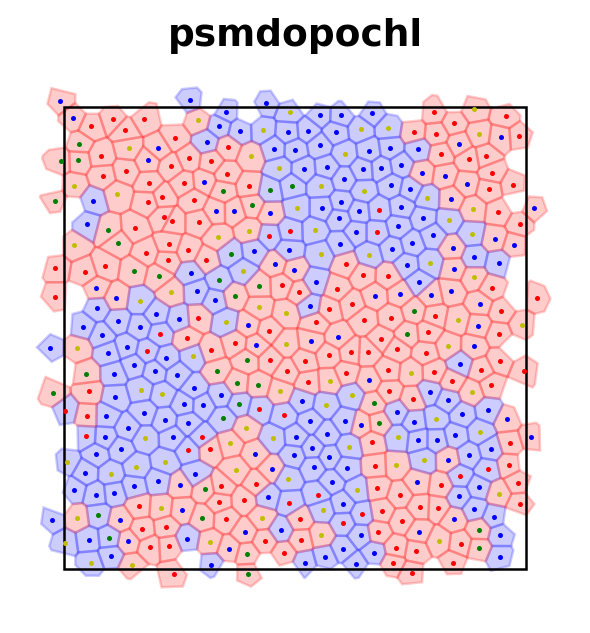

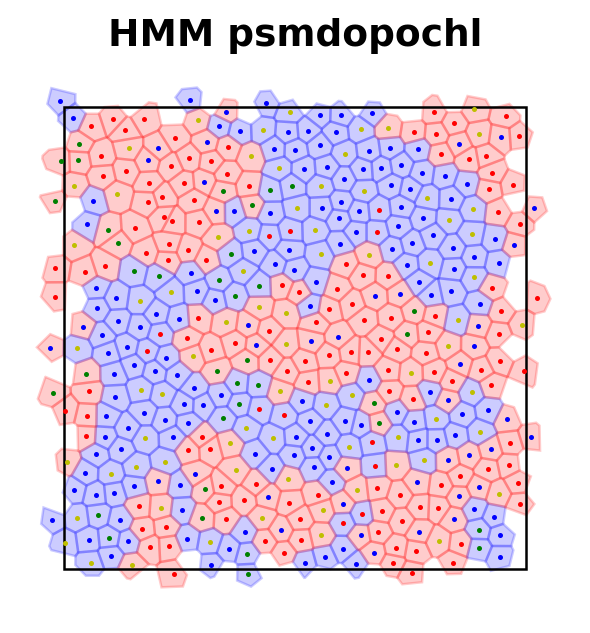

In [24]:
#考虑周期性边界条件的Voronoi tessellation
import MDAnalysis
from scipy.spatial import Voronoi
import numpy as np
import argparse
import math
import matplotlib.pyplot as plt
import matplotlib
from scipy.spatial import Voronoi, ConvexHull
from collections import Counter

# 一些函数###########################################################################################################################
# 函数get_atom分别获得磷脂的两条疏水链的原子
def get_sn(sel_lip, sel_lip_type):
	sel_atom =[]
	for i in range(len(sel_lip)):
		if(sel_lip_type[i] == 'DPPC'):
			tmp_sn1 = sel_lip[i] + ' and (name C32 H2X H2Y C33 H3X H3Y C34 H4X H4Y C35 H5X H5Y C36 H6X H6Y C37 H7X H7Y\
									  C38 H8X H8Y C39 H9X H9Y C310 H10X H10Y C311 H11X H11Y C312 H12X H12Y C313 H13X H13Y\
									  C314 H14X H14Y C315 H15X H15Y C316 H16X H16Y H16Z)'
			tmp_sn2 = sel_lip[i] + ' and (name C22 H2R H2S C23 H3R H3S C24 H4R H4S C25 H5R H5S C26 H6R H6S C27 H7R H7S\
									  C28 H8R H8S C29 H9R H9S C210 H10R H10S C211 H11R H11S C212 H12R H12S C213 H13R H13S\
									  C214 H14R H14S C215 H15R H15S C216 H16R H16S H16T)'
		elif(sel_lip_type[i] == 'DOPC'):
			tmp_sn1 = sel_lip[i] + ' and (name C32 H2X H2Y C33 H3X H3Y C34 H4X H4Y C35 H5X H5Y C36 H6X H6Y C37 H7X H7Y\
									  C38 H8X H8Y C39 H9X C310 H10X C311 H11X H11Y C312 H12X H12Y C313 H13X H13Y\
									  C314 H14X H14Y C315 H15X H15Y C316 H16X H16Y C317 H17X H17Y C318 H18X H18Y H18Z)'
			tmp_sn2 = sel_lip[i] + ' and (name C22 H2R H2S C23 H3R H3S C24 H4R H4S C25 H5R H5S C26 H6R H6S C27 H7R H7S\
									  C28 H8R H8S C29 H9R C210 H10R C211 H11R H11S C212 H12R H12S C213 H13R H13S\
									  C214 H14R H14S C215 H15R H15S C216 H16R H16S C217 H17R H17S C218 H18R H18S H18T)' 
		elif(sel_lip_type[i] == 'POPC'):
			tmp_sn1 = sel_lip[i] + ' and (name C32 H2X H2Y C33 H3X H3Y C34 H4X H4Y C35 H5X H5Y C36 H6X H6Y C37 H7X H7Y\
									  C38 H8X H8Y C39 H9X H9Y C310 H10X H10Y C311 H11X H11Y C312 H12X H12Y C313 H13X H13Y\
									  C314 H14X H14Y C315 H15X H15Y C316 H16X H16Y H16Z)'
			tmp_sn2 = sel_lip[i] + ' and (name C22 H2R H2S C23 H3R H3S C24 H4R H4S C25 H5R H5S C26 H6R H6S C27 H7R H7S\
									  C28 H8R H8S C29 H91 C210 H101 C211 H11R H11S C212 H12R H12S C213 H13R H13S\
									  C214 H14R H14S C215 H15R H15S C216 H16R H16S C217 H17R H17S C218 H18R H18S H18T)'
		elif(sel_lip_type[i] == 'PSM'):
			tmp_sn1 = sel_lip[i] + ' and (name C2F H2F C3F H3F C4F H4F C5F H5F C6F H6F C7F H7F \
									  C8F H8F C9F H9F C10F H10F C11F H11F C12F H12F C13F H13F \
									  C14F H14F C15F H15F C16F H16F C2F H2G C3F H3G C4F H4G C5F H5G C6F H6G C7F H7G \
									   C8F H8G C9F H9G C10F H10G C11F H11G C12F H12G C13F H13G \
									   C14F H14G C15F H15G C16F H16G H16H)'
			tmp_sn2 = sel_lip[i] + ' and (name C6S H6S C7S H7S C8S H8S C9S H9S C10S H10S C11S H11S C12S H12S C13S H13S \
									  C14S H14S C15S H15S C16S H16S C17S H17S C18S H18S C6S H6T C7S H7T C8S H8T C9S H9T C10S H10T C11S H11T C12S H12T C13S H13T \
									  C14S H14T C15S H15T C16S H16T C17S H17T C18S H18T H18U)'
		sel_atom.append(tmp_sn1)
		sel_atom.append(tmp_sn2)
	return sel_atom
def getPolygonArea(points):

	sizep = len(points)
	if sizep<3:
		return 0.0

	area = points[-1][0] * points[0][1] - points[0][0] * points[-1][1]
	for i in range(1, sizep):
		v = i - 1
		area += (points[v][0] * points[i][1])
		area -= (points[i][0] * points[v][1])

	return abs(0.5 * area)
def calculate_lipid_Voronoi_area(points):
	# 计算 Voronoi 分割
	vor = Voronoi(points)
	#按照 points 的顺序对 vor.regions 进行排序
	sorted_regions = [vor.regions[vor.point_region[i]] for i in range(len(points))]
	# 计算每个 Voronoi 区域的面积
	areas = []
	boundary_points = []
	for region in sorted_regions:
		if -1 in region or len(region) == 0:
			# 跳过无效的区域
			areas.append(0)
			boundary_points.append(list(points[i]))
			continue
		# 获取区域的顶点坐标
		vertices = vor.vertices[region]
		# 计算区域的凸包
		area=getPolygonArea(vertices)
		# print('area',area)
		areas.append(area)
	# 检查
	if (len(areas) == len(points)):
		print('                     V_AREAS NUM CORRECT')
	else:
		print('!                    V_AREAS NUM ERROR')

	return areas, vor, sorted_regions, boundary_points
def plot_Voronoi(vor, sorted_regions, points, n_count, box, phase, title_str): #n_count = lip_num*2 + chol_num in one leaflet
	fig, ax = plt.subplots(figsize=(4, 4), dpi=180)
	# 多边形的画图部分
	for i in range(len(sorted_regions)):
		region = sorted_regions[i]
		if -1 in region or len(region) == 0:
			# 跳过无效的区域
			continue
		# 获取区域的顶点坐标
		vertices = vor.vertices[region]
		if(i < len(phase)):
			if(phase[i] == 1):
				ax.fill(*zip(*vertices), alpha=0.2, color='blue')
			elif(phase[i] == 0):
				ax.fill(*zip(*vertices), alpha=0.2, color='red')
		else:
			ax.fill(*zip(*vertices), alpha=0.0, color='white')        #PBC 多边形 

		# if(i<202*2):
		# # if(i<202*2 and i%2==0):
		#     ax.fill(*zip(*vertices), alpha=0.2, color='blue')          #DPPC 多边形
		# elif(i<404*2):
		# # elif(i<404*2 and i%2==0):
		#     #2个多边形融合
		#     ax.fill(*zip(*vertices), alpha=0.2, color='red')           #DOPC 多边形
		# elif(i<n_count):
		#     ax.fill(*zip(*vertices), alpha=0.2, color='orange')        #CHOL 多边形 
		# else:
		#     ax.fill(*zip(*vertices), alpha=0.1, color='grey')        #PBC 多边形 
			# break

	# 点的画图部分
	ax.plot(points[:180, 0], points[:180, 1], 'b.', markersize='2')               # psm 2疏水链脂心
	ax.plot(points[180:324, 0], points[180:324, 1], 'r.', markersize='2')     # dopc 2疏水链脂心
	ax.plot(points[324:360, 0], points[324:360, 1], 'g.', markersize='2')     # popc 2疏水链脂心
	ax.plot(points[360:n_count, 0], points[360:n_count, 1], 'y.', markersize='2') # chol O3        
	ax.plot(points[n_count:, 0], points[n_count:, 1], '.', color='white', markersize='2', alpha=0.0)            # PBC fake points
	# box画图部分                                        
	# 创建一个正方形的顶点坐标
	square = plt.Rectangle((0, 0), box[0], box[1], fill=False)
	# 将正方形添加到坐标轴上
	ax.add_patch(square)
	# 隐藏原始的坐标轴
	ax.axis('off')
	# 标记刻度和数字（仅显示左下两边的刻度和数字）
	# for i in range(20, 101, 40):
	#     # 左侧刻度及数字
	#     plt.plot([0, 2], [i, i], color='black')  # 刻度线
	#     plt.text(-3, i, str(i), ha='right', va='center')  # 数字标签
	#     # 下方刻度及数字
	#     plt.plot([i, i], [0, 2], color='black')  # 刻度线
	#     plt.text(i, -3, str(i), ha='center', va='top')  # 数字标签
	
	# ax.axis('off')

	x_min = 0-0.1*box[0]
	x_max = 1.1*box[0]
	y_min = 0-0.1*box[1]
	y_max = 1.1*box[1]
	plt.xlim(x_min, x_max)
	plt.ylim(y_min, y_max)
	plt.title(title_str, fontsize= 15, fontweight='bold')
	plt.gca().set_aspect('equal')
	plt.savefig(
	'/data/gulab/yzdai/data4/phase_identification/plot/output/voronoi/'+title_str+'.png',        # 文件名
	dpi=350,             # 分辨率
	format='png',        # 文件格式
	bbox_inches='tight', # 自动调整边界框
	pad_inches=0.0,      # 边界填充
	# facecolor='white',   # 背景颜色
	# edgecolor='black',   # 边缘颜色
	transparent=True,   # 是否透明背景
	# metadata={'Author': 'Your Name'}  # 元数据
	)       
def simulate_PBC(points_leaflet, box):  # 改成 points leaflet判断并移动
	PBC_points = []
	x_min = 0-0.1*box[0]
	x_max = 1.1*box[0]
	y_min = 0-0.1*box[1]
	y_max = 1.1*box[1]
	for i in range(len(points_leaflet)):
		# 左移 
		if(points_leaflet[i, 0] > box[0]*0.9):
			x = points_leaflet[i, 0] - box[0]
			y = points_leaflet[i, 1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])
		# 右移 
		if(points_leaflet[i, 0] < box[0]*0.1):
			x = points_leaflet[i, 0] + box[0]
			y = points_leaflet[i, 1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])
		# 上移 
		if(points_leaflet[i, 1] < box[1]*0.1):
			x = points_leaflet[i, 0]
			y = points_leaflet[i, 1] + box[1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])            
		# 下移 
		if(points_leaflet[i, 1] > box[1]*0.9):
			x = points_leaflet[i, 0]
			y = points_leaflet[i, 1] - box[1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])            
		# 左上移  
		if(points_leaflet[i, 0] > box[0]*0.9 and points_leaflet[i, 1] < box[1]*0.1):
			x = points_leaflet[i, 0] - box[0]
			y = points_leaflet[i, 1] + box[1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])            
		# 左下移
		if(points_leaflet[i, 0] > box[0]*0.9 and points_leaflet[i, 1] > box[1]*0.9):
			x = points_leaflet[i, 0] - box[0]
			y = points_leaflet[i, 1] - box[1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])            
		# 右上移
		if(points_leaflet[i, 0] < box[0]*0.1 and points_leaflet[i, 1] < box[1]*0.1):
			x = points_leaflet[i, 0] + box[0]
			y = points_leaflet[i, 1] + box[1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])           
		# 右下移
		if(points_leaflet[i, 0] < box[0]*0.1 and points_leaflet[i, 1] > box[1]*0.9):
			x = points_leaflet[i, 0] + box[0]
			y = points_leaflet[i, 1] - box[1]
			if(x > x_min and x < x_max and y > y_min and y < y_max):
				PBC_points.append([x, y])           
	PBC_points = np.array(PBC_points)
	return PBC_points
# 这里开始定义一个大函数，输入是每个片层选择的所有原子 包括chol
def leaflet_Vor(sel_atom_leaflet, count_leaflet_lip, box):
	# 获得所有Voronoi点的坐标
	points_leaflet = []
	for i in range(0, len(sel_atom_leaflet)):
		point = u.select_atoms(sel_atom_leaflet[i]).center_of_mass()
		points_leaflet.append(list(point[0:2]))
	points_leaflet = np.array(points_leaflet)
	# 记有效点数为 n_count == lip_num*2 + chol_num
	n_count = len(points_leaflet)

	# 对边界点进行8次处理
	PBC_points = simulate_PBC(points_leaflet, box)
	# 获得 points_with_PBC
	points_with_PBC = np.array(list(points_leaflet) + list(PBC_points))  # 直接在这里调函数simulate pbc

	print('PBC_points:\t' + str(len(PBC_points)) + '\tpoints_with_PBC:\t' + str(len(points_with_PBC)))
	# 对points_with_PBC进行Voronio tessellation 
	areas, vor, sorted_regions, _boundary_points = calculate_lipid_Voronoi_area(points_with_PBC)

	areas = areas[:n_count] #这里是每个非PBC点的面积，接下来我们要获得每个脂质的面积
	chol_area = areas[-count_leaflet_lip*2:]
	lip_area = []
	for i in range(0,count_leaflet_lip*2,2):
		if(areas[i]==0 or areas[i+1]==0):
			print('!                    FINAL AREAS ZERO ERROR')
			break
		else:
			tmp = areas[i] + areas[i+1]
			lip_area.append(tmp)
	print('lip_area:\t' + str(len(lip_area)))
	return lip_area, chol_area, vor, sorted_regions, points_with_PBC
#识别共享边，确定相边界顶点，相边界索引
def share_boundary(vor,sorted_regions,tail_phase):
	i=0
	boundary_index=[]
	#选定一个区域作为中心区域
	m=0 
	# boundary_vertices=np.zeros((1,2))
	for i in range ( len(sorted_regions)):
		region=sorted_regions[i]   
		region_adjacent=[]
		region_adjacent_index=[]
		j=0
		#确定中心区域旁的相邻区域
		for tmp in sorted_regions:
			if len( list(set(region) & set(tmp)))>=2 and len( list(set(region) & set(tmp)))<len(region): #确定相邻区域，不包含中心区域
				share_vertices =  list(set(region) & set(tmp))
				region_adjacent.append(tmp)       
				region_adjacent_index.append(j)   #确定相邻区域的索引，不包含中心区域 
			j+=1
		#确定边界相区域1
		# share_vertices_num=0
		# for l in range(len(region_adjacent_index)):
		#     if len( list(set(region_adjacent[l]) & set(sorted_regions[i])))>0:
		#         # print( list(set(region_adjacent[l]) & set(sorted_regions[i])))
		#         share_vertices_num+=1
		#     if tail_phase[region_adjacent_index[l]]!=tail_phase[i] and share_vertices_num<3: #确定相邻区域与中心区域相态是否相同，若不同则中心区域为边界相区域
		#                                     #由于遍历所有区域，因此只需要判断中心区域是否为边界相区域，从而可得所有边界相区域
		#         boundary_index.append(i) 
		#         break
		#确定边界相区域2
		phase0_num=0
		phase1_num=0
		b_mol_if='no'
		for l in range(len(region_adjacent_index)):
			if tail_phase[region_adjacent_index[l]]==0 :
				phase0_num+=1
			else:
				# print( list(set(region_adjacent[l]) & set(sorted_regions[i])))
				phase1_num+=1
		for l in range(len(region_adjacent_index)):
			if tail_phase[region_adjacent_index[l]]!=tail_phase[i]:
				b_mol_if='yes'
				break
		if b_mol_if=='yes' and not \
		(phase0_num>len(region_adjacent_index)-2 or  phase1_num>len(region_adjacent_index)-2): #确定相邻区域与中心区域相态是否相同，若不同则中心区域为边界相区域
											#由于遍历所有区域，因此只需要判断中心区域是否为边界相区域，从而可得所有边界相区域
			boundary_index.append(i)           
		#确定边界点
		for k in region_adjacent_index:
			if tail_phase[k]!=tail_phase[i]:                     
				vertices_around =vor.vertices[sorted_regions[k]] #确定相邻区域的顶点
				vertices_center =vor.vertices[sorted_regions[i]] #确定中心区域的顶点
				# print(vor.vertices[sorted_regions[k]])
				# print(vor.vertices[sorted_regions[i]])
				for tmp_c in vertices_center:                    #确定与中心区域相同的顶点，即边界点
					for tmp_a in vertices_around:
						if tmp_c[0]==tmp_a[0] and tmp_c[1]==tmp_a[1]:
							if m==0:
								boundary_vertices=tmp_c                                   
								m+=1
							else: boundary_vertices=np.concatenate((boundary_vertices,tmp_c)) #将所有边界点结合到一起,相邻两个为共享边
				
	boundary_vertices=boundary_vertices.reshape(int(len(boundary_vertices)/2),2)

	return boundary_vertices,boundary_index
def area_phase(sorted_regions,tail_phase,boundary_vertices,areas_all):
	i=0
	area_phase0=[]
	area_phase1=[]
	boundary_index=[]
	#确定区域相态
	for i in range ( len(sorted_regions)):
		j=0
		if tail_phase[i]==0:
			area_phase0.append(areas_all[i])
		else:
			area_phase1.append(areas_all[i])
	area_phase0_sum=sum(area_phase0)
	area_phase1_sum=sum(area_phase1)
	length_all=[]
	
	for i in range(0,boundary_vertices.shape[0],2):
		length = np.linalg.norm(boundary_vertices[i+1] - boundary_vertices[i])
		length_all.append(length)
	length_sum=sum(length_all)
	print('area_sum;','area_phase0_sum;','area_phase1_sum;','length_sum;','A_0/L')
	print(np.sum(areas_all),area_phase0_sum,area_phase1_sum,length_sum,area_phase0_sum/length_sum)
	R_0=area_phase0_sum/length_sum
	return np.sum(areas_all),area_phase0_sum,area_phase1_sum,length_sum,R_0
# MAIN###########################################################################################################################
lip_leaflet_raw = np.loadtxt(fn_leaflet)[:,1:]
# 获得单片层lip type without CHOL
sel_lip_type_upper = ['PSM' for x in range(90)] + ['DOPC' for x in range(72)] + ['POPC' for x in range(18)]
sel_lip_type_lower = ['PSM' for x in range(90)] + ['DOPC' for x in range(72)] + ['POPC' for x in range(18)]
# 获得上片层磷脂的resid
lip_upper_ndx = list(np.array(list(range(1,91)) + list(range(181,253)) + list(range(477, 495)))-1)
sel_lip_upper = list(range(1,91)) + list(range(181,253)) + list(range(477, 495))
for i in range(0,len(sel_lip_upper)):
	sel_lip_upper[i] = 'resid '+str(sel_lip_upper[i])
# 获得下片层磷脂的resid
lip_lower_ndx = list(np.array(list(range(91, 181)) + list(range(253, 325)) + list(range(495, 513)))-1)
sel_lip_lower = list(range(91, 181)) + list(range(253, 325)) + list(range(495, 513))
for i in range(0,len(sel_lip_lower)):
	sel_lip_lower[i] = 'resid '+str(sel_lip_lower[i])

all_chol_id = [int(x) for x in range(325,401)] + [int(x) for x in range(401,477)]

u = MDAnalysis.Universe(pdb, trj)
for ts in u.trajectory[b:e:interval]:   #最后5ns的结果
	# 载入phase信息
	atom_phase_all = list(np.loadtxt(atom_phase_fn)[-1,1:])
	HMMphase = np.loadtxt(HMM_phase_fn)[:,1:]
	if (sum(HMMphase[:,0] == 0) > sum(HMMphase[:,0] == 1)):
		HMMphase = 1 - HMMphase
	HMM_phase_all = list(HMMphase[-1,:])   ####

	chl_resname = 'CHL1'
	fn_leaflets = lip_leaflet_raw[int(ts.frame)-15000:int(ts.frame)+interval-15000, :]
	most_common_leaflet_tag = [Counter(column).most_common(1)[0][0] for column in zip(*fn_leaflets)]
	sel_upper_chol=[]; sel_lower_chol=[]
	atom_phase_upper_chol=[]; atom_phase_lower_chol=[]
	HMM_phase_upper_chol=[]; HMM_phase_lower_chol=[]
	for chol_id in all_chol_id:
		index = chol_id - 1
		leaflet_tag = most_common_leaflet_tag[index]
		atom_phase_tag = atom_phase_all[index]
		HMM_phase_tag = HMM_phase_all[index]
		if leaflet_tag == 0:
			sel_upper_chol.append(chol_id)
			atom_phase_upper_chol.append(atom_phase_tag)
			HMM_phase_upper_chol.append(HMM_phase_tag)
		else:
			sel_lower_chol.append(chol_id)
			atom_phase_lower_chol.append(atom_phase_tag)
			HMM_phase_lower_chol.append(HMM_phase_tag)
	atom_phase_upper_lip = [item for item in np.array(atom_phase_all)[lip_upper_ndx] for _ in range(2)]
	atom_phase_lower_lip = [item for item in np.array(atom_phase_all)[lip_lower_ndx] for _ in range(2)]
	HMM_phase_upper_lip = [item for item in np.array(HMM_phase_all)[lip_upper_ndx] for _ in range(2)]
	HMM_phase_lower_lip = [item for item in np.array(HMM_phase_all)[lip_lower_ndx] for _ in range(2)]
	atom_phase_of_points_up = atom_phase_upper_lip + atom_phase_upper_chol
	atom_phase_of_points_low = atom_phase_lower_lip + atom_phase_lower_chol
	HMM_phase_of_points_up = HMM_phase_upper_lip + HMM_phase_upper_chol
	HMM_phase_of_points_low = HMM_phase_lower_lip + HMM_phase_lower_chol

	count_upper_chol = len(sel_upper_chol)
	count_lower_chol = len(sel_lower_chol)
	# 取上下片层磷脂疏水链原子
	sel_atom_upper = get_sn(sel_lip_upper, sel_lip_type_upper)
	sel_atom_lower = get_sn(sel_lip_lower, sel_lip_type_lower)

	for i in range(count_upper_chol):
		tmp = 'resname ' + chl_resname + ' and resid ' + str(sel_upper_chol[i]) + ' '# + 'and name ' + chl_atomname
		sel_atom_upper.append(tmp)
	for i in range(count_lower_chol):
		tmp = 'resname ' + chl_resname + ' and resid ' + str(sel_lower_chol[i]) + ' '# + ' and name ' + chl_atomname
		sel_atom_lower.append(tmp)
	print('upper atoms:\t' + str(len(sel_atom_upper)) + '\tlower atoms:\t' + str(len(sel_atom_lower)))

	count_leaflet_lip = 180  # 不同体系需要改
	box = ts.dimensions[:3]

	n_count_up =  count_leaflet_lip*2 + count_upper_chol #points的数量。每个脂质2个point,每个chol一个point
	n_count_low = count_leaflet_lip*2 + count_lower_chol
for ts in u.trajectory[e:e+1]: 
	print('upper--------------------------------------------------')
	lip_area_up, chol_area_up, vor_up, sorted_regions_up, points_all_up = leaflet_Vor(sel_atom_upper, count_leaflet_lip, box)
	print('lower--------------------------------------------------')
	lip_area_low, chol_area_low, vor_low, sorted_regions_low, points_all_low = leaflet_Vor(sel_atom_lower, count_leaflet_lip, box)
	print('-------------------------------------------------------')
	print('n_count_up:\t' + str(n_count_up) + '\tn_count_low:\t' + str(n_count_low))
	print('points_all_up:\t' + str(len(points_all_up)) + '\tpoints_all_low:\t' + str(len(points_all_low)))

	# visualization atom density
	plot_Voronoi(vor_up, sorted_regions_up, points_all_up, n_count_up, box, atom_phase_of_points_up, title_str = sys)
	plot_Voronoi(vor_up, sorted_regions_up, points_all_up, n_count_up, box, HMM_phase_of_points_up, title_str = "HMM " + sys)
	

In [73]:
import itertools
def correct_min_repeat_tags(segments, repeat = 2):
	for r in range(1, repeat+1):
		print('r = ',r)
		iter = 0
		while True:
			iter += 1
			print('1st: iter: ' + str(iter))
			corrected_segments = segments.copy()
			for i in range(len(segments)):
				char, count = segments[i]
				if(len(segments) >= 3):
					if count <= r:
						if i == 0 and len(segments) > 1:
							# 首个segment的处理
							right_char, right_count = segments[i+1]
							if right_count > repeat:
								corrected_segments[i] = (right_char, count)
						elif i == len(segments) - 1 and len(segments) > 1:
							# 末尾segment的处理
							left_char, left_count = segments[i-1]
							if left_count > repeat:
								corrected_segments[i] = (left_char, count)
						else:
							# 中间segment的处理
							left_char, left_count = segments[i-1]
							right_char, right_count = segments[i+1]
							
							if left_count > r or right_count > r:
								if left_count >= right_count:
									corrected_segments[i] = (left_char, count)
								else:
									corrected_segments[i] = (right_char, count)
				else:
					if count <= repeat:
						if (i + 1 < len(segments)):
							right_char, right_count = segments[i+1]
							corrected_segments[i] = (right_char, count)
						else:
							left_char, left_count = segments[i-1]
							corrected_segments[i] = (left_char, count)
			cor_seq = merge_segments(corrected_segments)
			print(cor_seq)
			segments = split_into_segments(cor_seq)
			
			if r < repeat:
				if all(count > r for char, count in segments[1:-1]) \
				   and len(segments)>=3:
					break
				elif( len(segments)<3):
					break
			else:
				if all(count > r for char, count in segments):
					break
	return segments
def temporal_smoothing (matrix):
	columns = [matrix[:, i].tolist() for i in range(matrix.shape[1])]
	new_columns = []
	for sequence in columns:
		# print('raw sequence:',end = ' ')
		# print(sequence)
		sequence    = [str(x) for x in sequence]
		segments = split_into_segments(sequence)
		corrected_segs = correct_min_repeat_tags(segments)
		corrected_sequence = merge_segments(corrected_segs)
		corrected_sequence = [int(x) for x in corrected_sequence]
		new_columns.append(corrected_sequence) 
		# print('new sequence:',end = ' ')
		# print(final_corrected_sequence)
	new_array = np.array(list(map(np.array, zip(*new_columns))))
	return new_array
def split_into_segments(sequence):
	segments = [(key, len(list(group))) for key, group in itertools.groupby(sequence)]
	return segments
def merge_segments(segments):
	tmp = list(''.join([char * count for char, count in segments]))
	return tmp



In [74]:
matrix = np.array([[1,0,0,1,0],
		  [1,1,1,0,0],
		  [0,1,0,1,0],
		  [0,0,0,0,0],
		  [0,0,0,0,0],
		  [0,0,0,0,0],
		  [1,1,0,1,0],
		  [1,1,0,1,0],
		  [1,1,0,1,0],
		  [0,0,1,0,0],
		  [0,0,1,0,0],
		  [1,0,1,0,0],
		  [0,0,0,0,0],
		  [1,0,0,0,0],
		  [0,0,0,0,0],
		  [0,0,1,1,0],
		  [1,1,1,0,0],
		  [1,0,0,1,0]])
print(matrix)
A = temporal_smoothing(matrix)
print(A)

[[1 0 0 1 0]
 [1 1 1 0 0]
 [0 1 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 1 0 1 0]
 [1 1 0 1 0]
 [1 1 0 1 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [1 0 1 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 1 1 0]
 [1 1 1 0 0]
 [1 0 0 1 0]]
r =  1
1st: iter: 1
['1', '1', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1']
r =  2
1st: iter: 1
['0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0']
r =  1
1st: iter: 1
['0', '1', '1', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0']
r =  2
1st: iter: 1
['0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0']
r =  1
1st: iter: 1
['0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '1', '1', '0']
r =  2
1st: iter: 1
['0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0']
r =  1
1st: iter: 1
['1', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0'

In [9]:
#考虑周期性边界条件的Voronoi tessellation
import MDAnalysis
from scipy.spatial import Voronoi
import numpy as np
import argparse
import math
import matplotlib.pyplot as plt
import matplotlib
from scipy.spatial import Voronoi, ConvexHull
from collections import Counter
def get_sn(sel_lip, sel_lip_type):
	sel_atom =[]
	for i in range(len(sel_lip)):
		if(sel_lip_type[i] == 'DPPC'):
			tmp_sn1 = sel_lip[i] + ' and (name C32 H2X H2Y C33 H3X H3Y C34 H4X H4Y C35 H5X H5Y C36 H6X H6Y C37 H7X H7Y\
									  C38 H8X H8Y C39 H9X H9Y C310 H10X H10Y C311 H11X H11Y C312 H12X H12Y C313 H13X H13Y\
									  C314 H14X H14Y C315 H15X H15Y C316 H16X H16Y H16Z)'
			tmp_sn2 = sel_lip[i] + ' and (name C22 H2R H2S C23 H3R H3S C24 H4R H4S C25 H5R H5S C26 H6R H6S C27 H7R H7S\
									  C28 H8R H8S C29 H9R H9S C210 H10R H10S C211 H11R H11S C212 H12R H12S C213 H13R H13S\
									  C214 H14R H14S C215 H15R H15S C216 H16R H16S H16T)'
		elif(sel_lip_type[i] == 'DOPC'):
			tmp_sn1 = sel_lip[i] + ' and (name C32 H2X H2Y C33 H3X H3Y C34 H4X H4Y C35 H5X H5Y C36 H6X H6Y C37 H7X H7Y\
									  C38 H8X H8Y C39 H9X C310 H10X C311 H11X H11Y C312 H12X H12Y C313 H13X H13Y\
									  C314 H14X H14Y C315 H15X H15Y C316 H16X H16Y C317 H17X H17Y C318 H18X H18Y H18Z)'
			tmp_sn2 = sel_lip[i] + ' and (name C22 H2R H2S C23 H3R H3S C24 H4R H4S C25 H5R H5S C26 H6R H6S C27 H7R H7S\
									  C28 H8R H8S C29 H9R C210 H10R C211 H11R H11S C212 H12R H12S C213 H13R H13S\
									  C214 H14R H14S C215 H15R H15S C216 H16R H16S C217 H17R H17S C218 H18R H18S H18T)' 
		elif(sel_lip_type[i] == 'POPC'):
			tmp_sn1 = sel_lip[i] + ' and (name C32 H2X H2Y C33 H3X H3Y C34 H4X H4Y C35 H5X H5Y C36 H6X H6Y C37 H7X H7Y\
									  C38 H8X H8Y C39 H9X H9Y C310 H10X H10Y C311 H11X H11Y C312 H12X H12Y C313 H13X H13Y\
									  C314 H14X H14Y C315 H15X H15Y C316 H16X H16Y H16Z)'
			tmp_sn2 = sel_lip[i] + ' and (name C22 H2R H2S C23 H3R H3S C24 H4R H4S C25 H5R H5S C26 H6R H6S C27 H7R H7S\
									  C28 H8R H8S C29 H91 C210 H101 C211 H11R H11S C212 H12R H12S C213 H13R H13S\
									  C214 H14R H14S C215 H15R H15S C216 H16R H16S C217 H17R H17S C218 H18R H18S H18T)'
		elif(sel_lip_type[i] == 'PSM'):
			tmp_sn1 = sel_lip[i] + ' and (name C2F H2F C3F H3F C4F H4F C5F H5F C6F H6F C7F H7F \
									  C8F H8F C9F H9F C10F H10F C11F H11F C12F H12F C13F H13F \
									  C14F H14F C15F H15F C16F H16F C2F H2G C3F H3G C4F H4G C5F H5G C6F H6G C7F H7G \
									   C8F H8G C9F H9G C10F H10G C11F H11G C12F H12G C13F H13G \
									   C14F H14G C15F H15G C16F H16G H16H)'
			tmp_sn2 = sel_lip[i] + ' and (name C6S H6S C7S H7S C8S H8S C9S H9S C10S H10S C11S H11S C12S H12S C13S H13S \
									  C14S H14S C15S H15S C16S H16S C17S H17S C18S H18S C6S H6T C7S H7T C8S H8T C9S H9T C10S H10T C11S H11T C12S H12T C13S H13T \
									  C14S H14T C15S H15T C16S H16T C17S H17T C18S H18T H18U)'
		sel_atom.append(tmp_sn1)
		sel_atom.append(tmp_sn2)
	return sel_atom
u = MDAnalysis.Universe(pdb, trj)
for ts in u.trajectory[e:e+1]:   #最后5ns的结果
	r = get_sn(['resid 1'], ['PSM'])
	points = u.select_atoms(r[0]).positions
	print(points.shape)
print(r)

(46, 3)
['resid 1 and (name C2F H2F C3F H3F C4F H4F C5F H5F C6F H6F C7F H7F \t\t\t\t\t\t\t\t\t  C8F H8F C9F H9F C10F H10F C11F H11F C12F H12F C13F H13F \t\t\t\t\t\t\t\t\t  C14F H14F C15F H15F C16F H16F C2F H2G C3F H3G C4F H4G C5F H5G C6F H6G C7F H7G \t\t\t\t\t\t\t\t\t   C8F H8G C9F H9G C10F H10G C11F H11G C12F H12G C13F H13G \t\t\t\t\t\t\t\t\t   C14F H14G C15F H15G C16F H16G H16H)', 'resid 1 and (name C6S H6S C7S H7S C8S H8S C9S H9S C10S H10S C11S H11S C12S H12S C13S H13S \t\t\t\t\t\t\t\t\t  C14S H14S C15S H15S C16S H16S C17S H17S C18S H18S C6S H6T C7S H7T C8S H8T C9S H9T C10S H10T C11S H11T C12S H12T C13S H13T \t\t\t\t\t\t\t\t\t  C14S H14T C15S H15T C16S H16T C17S H17T C18S H18T H18U)']


In [ ]:
C32 C33 C34 C35 C36 C37 C38 C39 C310 C311 C312 C313 C314 C315 C316 C22 C23 C24 C25 C26 C27 C28 C29 C210 C211 C212 C213 C214 C215 C216 C217 C218
